# Preprocess data files

In [13]:
# Get starting frame timestamps for all the clips

import glob
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Relative path, no need to change
script_path = '../script/'

# Absolute path, change it according to data locations
data_path = '../../data/'
feature_path = '../../features/'

def save_header(device):
    
    freq_st = []
    acc_st = []
    
    sequences = ['capture' + str(i) +'.seq' 
                 for i in range(len(glob.glob(data_path + device + '/capture*')))]
    
    for i in range(len(sequences)):
        folder = data_path + device + '/capture' + str(i) +'.seq/'
        f = open(glob.glob(folder + '*.head')[0], 'rb')
        header = pickle.load(f)
        freq_st.append(header['frequency_start'])
        acc_st.append(header['access_history_start'])
    
    timestamps = [sequences, freq_st, acc_st]
    
    df = pd.DataFrame (timestamps).transpose()
    df.columns = ['Sequences','Frequency Start','Access History Start']
    
    df.to_csv(data_path + device + '/deeplens_' + device.split('iotlab_')[-1] + '_timestamps.csv')
    return df

In [14]:
import datetime

def time2datetime(data):
    datetime_li = []
    
    for time in data['frame.time'].tolist():
        date_time_str = time.split('000 CDT')[0]
        date_time_obj = datetime.datetime.strptime(date_time_str, '%b %d, %Y  %H:%M:%S.%f')
        datetime_li.append(date_time_obj)
        
    return(datetime_li)

## Split by timestamps


In [4]:
import os
def cut_pcaps(df_ts, device):
    status = device.split('iotlab_')[-1]
    for i in range(len(df_ts['Frequency Start'].tolist())):
        start_time = df_ts['Frequency Start'][i].strftime("%Y-%m-%d %H:%M:%S")
        if i == len(df_ts['Frequency Start'].tolist()) - 1:
            end_time = (df_ts['Frequency Start'][i] 
                        + datetime.timedelta(seconds=30)).strftime("%Y-%m-%d %H:%M:%S")
        else:
            end_time = (df_ts['Frequency Start'][i+1] 
                        + datetime.timedelta(seconds=1)).strftime("%Y-%m-%d %H:%M:%S")
        cmd = ('editcap -A "' + start_time + '" -B "' 
               + end_time + '" ' + data_path + device + '/deeplens_' 
               + status + '.pcap ' + data_path + device + '/capture' + str(i) + '.seq/deeplens_' 
               + status + '_' + str(i) + '.pcap' )
        os.system(cmd)

In [5]:
def pcaps_time(activity):
    pcap_whole = data_path + activity + '/deeplens_' + activity.split('iotlab_')[-1] + '.pcap'
    # transform into csv, used pcap2csv.sh
    os.system('tshark -r ' + pcap_whole + ' -T fields -e frame.number \
              -e frame.time -e frame.time_delta -e frame.time_relative \
              -e eth.src_resolved -e eth.dst_resolved -e eth.src -e eth.dst \
              -e eth.type -e ip.version -e ip.hdr_len -e ip.len -e ip.id \
              -e ip.flags.df -e ip.flags.mf -e ip.flags.rb -e ip.flags.sf \
              -e ip.dsfield.dscp -e ip.dsfield.ecn -e ip.tos -e ip.ttl \
              -e ip.proto -e ip.src -e ip.dst -e udp.srcport -e udp.dstport \
              -e udp.length -e tcp.flags.cwr -e tcp.flags.ecn -e tcp.flags.urg \
              -e tcp.flags.ack -e tcp.flags.push -e tcp.flags.reset \
              -e tcp.flags.syn -e tcp.flags.fin -e tcp.flags.res -e tcp.flags.ns \
              -e tcp.payload -e tcp.len -e frame.len -E header=y -E separator=\| > '+ pcap_whole + '.csv')
    
    df_act_ts = save_header(activity)
    df_act = pd.read_csv(pcap_whole + '.csv', sep = '|') 
    
    df_act['frame.time'] = time2datetime(df_act)
    cut_pcaps(df_act_ts, activity)

In [80]:
# activities = ['iotlab_idle','iotlab_open_fridge','iotlab_open_dryer','iotlab_open_washer','iotlab_open_shut_fridge',
#               'iotlab_open_dishwasher','iotlab_open_faucet_fridge','iotlab_open_lower_fridge']

# activities = ['iotlab_open_shut_fridge','iotlab_open_faucet_fridge','iotlab_open_lower_fridge']
activities = ['iotlab_browse_app_fridge']

for activity in activities:
    pcaps_time(activity)

/Users/shinanliu/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (9,10,11,13,14,15,17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [15]:
os.system('./pcap2csv.sh')

0

## Filter ip addresses and initiate folder structure
* IP addresses of the dishwasher, washer and dryer are unknown.
    * Inspect by using wireshark
        * What is 192.168.143.104? This is the major traffic in every pcap. Camera?
        * dishwasher: 192.168.143.77 / 76
        * Try to plot all traffics and see the patterns over the whole time span.
* Filter by tshark first, and get the csv files of them.
    * Double direction, not just source
    * Construct normal traffic at the same time, which makes more sense

In [ ]:
# Filter out all other devices based on IP address
# Since other devices' IP/MAC addresses are not clear yet, try Referigerators first

In [18]:
glob.glob(data_path + 'iotlab_o*')

['../../data/iotlab_open_shut_fridge',
 '../../data/iotlab_open_fridge',
 '../../data/iotlab_open_faucet_fridge',
 '../../data/iotlab_open_lower_fridge',
 '../../data/iotlab_open_dryer',
 '../../data/iotlab_open_washer',
 '../../data/iotlab_open_dishwasher']

In [20]:
def ft_str(activity):
    os.system('mkdir ' + feature_path + activity)
    os.system('mkdir ' + feature_path + activity + '/csv')
    os.system('mkdir ' + feature_path + activity + '/netml-features')
    os.system('mkdir ' + feature_path + activity + '/nPrint')
    
for path in glob.glob(data_path + 'iotlab_o*'):
    activity = path.split('/')[-1]
    print(activity)
    ft_str(activity)

iotlab_open_shut_fridge
iotlab_open_fridge
iotlab_open_faucet_fridge
iotlab_open_lower_fridge
iotlab_open_dryer
iotlab_open_washer
iotlab_open_dishwasher


In [46]:
def pcap_by_ip(activity, ip):
    os.system('cp ' + script_path + 'ipfilter_pcap2csv.sh ' + data_path + activity)
    os.system('chmod +x ' + data_path + activity + '/ipfilter_pcap2csv.sh')
    os.system('cd ' + data_path + activity + ' & sh ipfilter_pcap2csv.sh ' + ip + ' ' + activity) ## Should fix the path issue
#     os.system('rm ' + data_path + activity + '/ipfilter_pcap2csv.sh')
    
pcap_by_ip('iotlab_open_lower_fridge', '192.168.143.43')

## Generate features

In [ ]:
## flow bucket


### netml

In [6]:
def browse_link(file_path):
    # for file in glob.glob()
    pp = PP._pcap2flows(file)
    pkt_li = []
    k = 0
    for i in range(len(pp)):
        # print out infos for the last flow
#         print(pp[i])
        if pp[i][0][0] == '192.168.143.43' or pp[i][0][1] == '192.168.143.43':
            pkt_li.append(len(pp[i][1]))
            k += 1

    print(k, pkt_li)

In [85]:
file = data_path + 'iotlab_idle_daily/iotlab_idle_daily_filtered/trace-20200813080032_filtered.pcap'
browse_link(file)

pcap_file: ../../data/iotlab_idle_daily/iotlab_idle_daily_filtered/trace-20200813080032_filtered.pcap
3666 [2996, 1616, 2, 13, 8, 1242, 635, 3498, 1386, 701, 13, 8, 8, 6, 8, 6, 4, 3, 8, 6, 8, 6, 5, 4, 4, 4, 13, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 241, 288, 13, 8, 13, 8, 13, 8, 13, 8, 15, 11, 15, 9, 15, 9, 1, 1, 13, 8, 13, 8, 13, 8, 13, 9, 13, 8, 13, 8, 13, 8, 13, 8, 8, 6, 8, 6, 5, 4, 8, 6, 8, 6, 5, 4, 13, 8, 13, 8, 13, 9, 13, 8, 13, 8, 13, 11, 13, 8, 13, 8, 1, 1, 13, 8, 13, 8, 13, 8, 1, 1, 13, 8, 13, 8, 13, 8, 8, 6, 8, 6, 5, 4, 8, 6, 8, 6, 5, 4, 13, 8, 13, 8, 13, 8, 1, 1, 13, 8, 13, 8, 13, 8, 13, 8, 13, 8,

In [83]:
# file = data_path + 'deeplens_install_app_fridge_batch_filtered.pcap'
file = data_path + 'iotlab_browse_app_fridge/deeplens_browse_app_fridge_filtered.pcap'
browse_link(file)

pcap_file: ../../data/iotlab_browse_app_fridge/deeplens_browse_app_fridge_filtered.pcap
1626 [14, 9, 77, 4604, 4841, 112, 80, 13, 9, 10, 4, 20, 504, 15, 585, 24, 27, 181, 113, 117, 179, 1315, 1755, 76, 44, 90, 47, 3, 4, 14379, 17103, 13, 9, 7, 8, 2, 14, 10, 1, 1, 42, 51, 68, 37, 13, 8, 54, 35, 44, 57, 26, 24, 141, 7, 7, 7, 5, 5, 5, 110, 25, 8, 26, 5, 12, 6, 12, 6, 1, 1, 13, 8, 4, 4, 411, 309, 40, 9, 60, 7, 216, 42, 87, 45, 10, 4, 20, 20, 20, 34, 20, 29, 52, 34, 35, 25, 11, 4, 19, 20, 20, 13, 6, 6, 13, 9, 13, 9, 83, 53, 13, 8, 13, 13, 9, 9, 13, 13, 9, 9, 11, 5, 11, 5, 2, 2, 760, 2563, 13, 8, 201, 60, 859, 1542, 27, 26, 22, 95, 21, 91, 22, 21, 1, 1, 201, 29, 28, 152, 199, 374, 81, 437, 13, 8, 9, 7, 300, 216, 9, 7, 9, 7, 9, 7, 13, 9, 10, 4, 10, 4, 10, 4, 13, 8, 11, 5, 23, 16, 338, 750, 1048, 3407, 13, 8, 830, 1834, 13, 8, 58, 30, 22, 28, 18, 16, 7, 4, 16, 10, 26, 15, 7, 5, 10, 270, 164, 5, 24, 16, 69, 57, 51, 9, 65, 5, 167, 721, 215, 59, 8, 69, 43, 379, 8, 28, 4, 5, 9, 5, 2, 2, 65, 74, 19

In [84]:
# file = data_path + 'deeplens_install_app_fridge_batch_filtered.pcap'
file = data_path + 'iotlab_open_shut_fridge_batch/deeplens_open_shut_fridge_batch_filtered.pcap'
browse_link(file)

pcap_file: ../../data/iotlab_open_shut_fridge_batch/deeplens_open_shut_fridge_batch_filtered.pcap
869 [6, 6, 92, 47, 313, 313, 2, 13, 8, 74, 29, 22, 72, 40, 27, 21, 28, 24, 17, 13, 27, 14, 22, 9, 26, 21, 14, 9, 26, 24, 17, 13, 2, 126, 94, 26, 22, 28, 22, 29, 25, 17, 13, 29, 22, 27, 20, 27, 23, 16, 12, 13, 9, 28, 21, 28, 22, 28, 23, 16, 12, 26, 22, 28, 22, 31, 24, 16, 12, 27, 19, 27, 22, 30, 27, 17, 14, 13, 8, 30, 21, 28, 23, 28, 24, 18, 14, 28, 22, 26, 22, 28, 23, 18, 14, 7, 13, 8, 2, 12, 27, 21, 26, 21, 28, 26, 17, 13, 6, 4, 2, 26, 20, 27, 20, 28, 25, 18, 14, 29, 21, 26, 21, 27, 22, 18, 14, 27, 21, 27, 23, 29, 25, 16, 12, 26, 23, 26, 21, 30, 25, 17, 13, 13, 8, 14, 11, 26, 20, 31, 24, 29, 28, 16, 12, 27, 21, 29, 22, 28, 23, 16, 12, 13, 9, 27, 21, 29, 24, 29, 24, 18, 14, 27, 20, 27, 22, 28, 21, 18, 14, 29, 24, 28, 23, 29, 25, 16, 12, 28, 22, 26, 22, 29, 23, 17, 13, 27, 20, 28, 21, 29, 25, 16, 12, 28, 22, 28, 23, 28, 26, 18, 14, 13, 8, 28, 25, 29, 23, 28, 24, 16, 12, 26, 22, 28, 23, 29, 

In [9]:
## Inspection
import os
import netml.pparser.parser as PP
from netml.pparser.parser import PCAP
from netml.utils.tool import dump_data

RANDOM_STATE = 42

for file in glob.glob(feature_path + 'iotlab_*/*.pcap'):
    print(file)
    pp = PP._pcap2flows(file)
    print(len(pp))
    for i in range(len(pp)):
        # print out infos for the last flow
        print(pp[i][0], len(pp[i][1])) # 5-tuples, packet number for each flow

../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_25_filtered.pcap
pcap_file: ../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_25_filtered.pcap
6
('50.16.143.220', '192.168.143.43', 443, 53410, 6) 2
('192.168.143.43', '50.16.143.220', 53410, 443, 6) 2
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 3
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 3
('192.168.143.43', '52.17.227.92', 32928, 443, 6) 2
../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_32_filtered.pcap
pcap_file: ../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_32_filtered.pcap
18
('192.168.143.43', '52.17.227.92', 32928, 443, 6) 2
('192.168.143.43', '3.88.95.55', 33213, 443, 6) 2
('192.168.143.43', '50.19.175.109', 34451, 443, 6) 9
('50.19.175.109', '192.168.143.43', 443, 34451, 6) 5
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 3
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 3
('192.168.143.43', '173

14
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 3
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 3
('192.168.143.43', '52.17.227.92', 32928, 443, 6) 2
('192.168.143.43', '34.213.250.213', 42481, 443, 6) 27
('34.213.250.213', '192.168.143.43', 443, 42481, 6) 21
('192.168.143.43', '34.213.250.213', 42482, 443, 6) 27
('34.213.250.213', '192.168.143.43', 443, 42482, 6) 22
('192.168.143.43', '34.213.250.213', 42483, 443, 6) 29
('34.213.250.213', '192.168.143.43', 443, 42483, 6) 26
('192.168.143.43', '34.213.250.213', 42484, 443, 6) 17
('34.213.250.213', '192.168.143.43', 443, 42484, 6) 13
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_9_filtered.pcap
pcap_file: ../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_9_filtered.pcap
11
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('192.168.143.43', 

13
('192.168.143.43', '44.227.156.20', 38576, 443, 6) 26
('44.227.156.20', '192.168.143.43', 443, 38576, 6) 22
('192.168.143.43', '44.227.156.20', 38577, 443, 6) 25
('44.227.156.20', '192.168.143.43', 443, 38577, 6) 20
('192.168.143.43', '44.227.156.20', 38578, 443, 6) 27
('44.227.156.20', '192.168.143.43', 443, 38578, 6) 25
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 3
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 3
('192.168.143.43', '44.227.156.20', 38579, 443, 6) 18
('44.227.156.20', '192.168.143.43', 443, 38579, 6) 15
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('192.168.143.43', '52.17.227.92', 32928, 443, 6) 2
../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_5_filtered.pcap
pcap_file: ../../features/iotlab_open_shut_fridge/deeplens_open_shut_fridge_5_filtered.pcap
14
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 3
('3.17.97.241', '192.168.14

3
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
../../features/iotlab_idle/deeplens_idle_54_filtered.pcap
pcap_file: ../../features/iotlab_idle/deeplens_idle_54_filtered.pcap
2
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
../../features/iotlab_idle/deeplens_idle_49_filtered.pcap
pcap_file: ../../features/iotlab_idle/deeplens_idle_49_filtered.pcap
2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
../../features/iotlab_idle/deeplens_idle_6_filtered.pcap
pcap_file: ../../features/iotlab_idle/deeplens_idle_6_filtered.pcap
3
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
../../features/iotlab_idle/deeplens_idle_17_filtered.pcap
pcap_file: ../../features/iotlab_idle/de

3
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
../../features/iotlab_idle/deeplens_idle_35_filtered.pcap
pcap_file: ../../features/iotlab_idle/deeplens_idle_35_filtered.pcap
4
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
../../features/iotlab_idle/deeplens_idle_22_filtered.pcap
pcap_file: ../../features/iotlab_idle/deeplens_idle_22_filtered.pcap
2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
../../features/iotlab_open_fridge/deeplens_open_fridge_20_filtered.pcap
pcap_file: ../../features/iotlab_open_fridge/deeplens_open_fridge_20_filtered.pcap
16
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 4
('3.15.66.241', '192.168.143.43', 443, 40441, 6) 4
('192.168.143.43

19
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 5
('3.15.66.241', '192.168.143.43', 443, 40441, 6) 5
('192.168.143.43', '23.51.230.100', 37094, 443, 6) 14
('23.51.230.100', '192.168.143.43', 443, 37094, 6) 11
('192.168.143.43', '54.171.9.173', 36531, 443, 6) 4
('54.171.9.173', '192.168.143.43', 443, 36531, 6) 2
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '34.218.155.240', 49809, 443, 6) 27
('34.218.155.240', '192.168.143.43', 443, 49809, 6) 20
('192.168.143.43', '34.218.155.240', 49810, 443, 6) 27
('34.218.155.240', '192.168.143.43', 443, 49810, 6) 22
('192.168.143.43', '34.218.155.240', 49811, 443, 6) 28
('34.218.155.240', '192.168.143.43', 443, 49811, 6) 24
('192.168.143.43', '34.218.155.240', 49812, 443, 6) 15
('34.218.155.240', '192.168.143.43', 443, 49812, 6) 12
('192.168.143.43', '34.218.155.240', 49813, 443, 6) 17
('34.218.155.240', '192.168.143.4

19
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 2
('3.15.66.241', '192.168.143.43', 443, 40441, 6) 2
('192.168.143.43', '54.171.9.173', 36531, 443, 6) 2
('192.168.143.43', '23.194.140.30', 36549, 443, 6) 14
('23.194.140.30', '192.168.143.43', 443, 36549, 6) 11
('192.168.143.43', '3.15.66.241', 40374, 443, 6) 2
('192.168.143.43', '23.194.140.30', 36550, 443, 6) 14
('23.194.140.30', '192.168.143.43', 443, 36550, 6) 9
('192.168.143.43', '52.34.107.21', 36949, 443, 6) 27
('52.34.107.21', '192.168.143.43', 443, 36949, 6) 21
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '52.34.107.21', 36950, 443, 6) 27
('52.34.107.21', '192.168.143.43', 443, 36950, 6) 21
('192.168.143.43', '52.34.107.21', 36951, 443, 6) 29
('52.34.107.21', '192.168.143.43', 443, 36951, 6) 26
('192.168.143.43', '52.34.107.21', 36952, 443, 6) 16
('52.34.107.21', '192.168.143.43', 443, 36952, 6) 12
('192.168.143.43', '52.34.107.21', 36953, 443, 6) 17
('52.34.107.21', '192.168.143.43', 443, 36953, 6

16
('192.168.143.43', '3.15.66.241', 40441, 443, 6) 4
('3.15.66.241', '192.168.143.43', 443, 40441, 6) 4
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '52.36.25.62', 55960, 443, 6) 26
('52.36.25.62', '192.168.143.43', 443, 55960, 6) 20
('192.168.143.43', '52.36.25.62', 55961, 443, 6) 27
('52.36.25.62', '192.168.143.43', 443, 55961, 6) 21
('192.168.143.43', '52.36.25.62', 55962, 443, 6) 27
('52.36.25.62', '192.168.143.43', 443, 55962, 6) 26
('192.168.143.43', '52.36.25.62', 55963, 443, 6) 16
('52.36.25.62', '192.168.143.43', 443, 55963, 6) 12
('192.168.143.43', '3.113.82.68', 35919, 5223, 6) 2
('192.168.143.43', '52.36.25.62', 55964, 443, 6) 17
('52.36.25.62', '192.168.143.43', 443, 55964, 6) 13
('192.168.143.43', '52.36.25.62', 55965, 443, 6) 16
('52.36.25.62', '192.168.143.43', 443, 55965, 6) 12
../../features/iotlab_open_fridge/deeplens_open_fridge_9_filtered.pcap
pcap_file: ../../features/iotlab_open_fridge/deeplens_open_fridge_9_filtered.pcap
17
('192.168.1

5
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('192.168.143.43', '34.228.154.103', 40352, 443, 6) 2
('192.168.143.43', '3.94.33.135', 54393, 443, 6) 9
('3.94.33.135', '192.168.143.43', 443, 54393, 6) 5
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_11_filtered.pcap
pcap_file: ../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_11_filtered.pcap
5
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('3.94.33.135', '192.168.143.43', 443, 54393, 6) 2
('192.168.143.43', '3.94.33.135', 54393, 443, 6) 2
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 2
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 2
../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_28_filtered.pcap
pcap_file: ../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_28_filtered.pcap
5
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '173.223.18.246', 43904, 443, 6) 15


7
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 5
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 5
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('3.94.33.135', '192.168.143.43', 443, 54400, 6) 2
('192.168.143.43', '3.94.33.135', 54400, 443, 6) 2
('192.168.143.43', '224.0.0.251', 5353, 5353, 17) 2
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_19_filtered.pcap
pcap_file: ../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_19_filtered.pcap
2
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_24_filtered.pcap
pcap_file: ../../features/iotlab_open_faucet_fridge/deeplens_open_faucet_fridge_24_filtered.pcap
7
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '52.6.56.226', 52746, 443, 6) 2
('192.

10
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 4
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 4
('192.168.143.43', '157.55.184.57', 34745, 443, 6) 8
('157.55.184.57', '192.168.143.43', 443, 34745, 6) 6
('192.168.143.43', '157.55.184.57', 34747, 443, 6) 8
('157.55.184.57', '192.168.143.43', 443, 34747, 6) 6
('192.168.143.43', '157.55.184.57', 48126, 80, 6) 7
('192.168.143.43', '52.19.88.186', 46086, 443, 6) 2
('157.55.184.57', '192.168.143.43', 80, 48126, 6) 2
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_19_filtered.pcap
pcap_file: ../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_19_filtered.pcap
6
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 2
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 2
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('192.168.143.43', '52.19.88.186', 46086, 443, 6) 2
('192.168.143.43', '224.0.0.251', 53

8
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 4
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 4
('192.168.143.43', '3.20.75.143', 54813, 443, 6) 2
('52.21.11.60', '192.168.143.43', 443, 46972, 6) 3
('192.168.143.43', '52.21.11.60', 46972, 443, 6) 4
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
('192.168.143.43', '104.17.128.1', 37833, 443, 6) 9
('104.17.128.1', '192.168.143.43', 443, 37833, 6) 7
../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_32_filtered.pcap
pcap_file: ../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_32_filtered.pcap
3
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 4
('3.17.97.241', '192.168.143.43', 443, 58384, 6) 4
('192.168.143.43', '52.193.155.55', 54816, 5223, 6) 2
../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_25_filtered.pcap
pcap_file: ../../features/iotlab_open_lower_fridge/deeplens_open_lower_fridge_25_filtered.pcap
4
('192.168.143.43', '3.17.97.241', 58384, 443, 6) 4
('3.17.97.241', 

2
('192.168.143.99', '3.219.230.115', 31191, 5225, 6) 4
('3.219.230.115', '192.168.143.99', 5225, 31191, 6) 4
../../features/iotlab_open_dryer/deeplens_open_dryer_27_filtered.pcap
pcap_file: ../../features/iotlab_open_dryer/deeplens_open_dryer_27_filtered.pcap
2
('192.168.143.99', '3.219.230.115', 31191, 5225, 6) 6
('3.219.230.115', '192.168.143.99', 5225, 31191, 6) 6
../../features/iotlab_open_dryer/deeplens_open_dryer_23_filtered.pcap
pcap_file: ../../features/iotlab_open_dryer/deeplens_open_dryer_23_filtered.pcap
2
('192.168.143.99', '3.219.230.115', 31191, 5225, 6) 5
('3.219.230.115', '192.168.143.99', 5225, 31191, 6) 5
../../features/iotlab_open_dryer/deeplens_open_dryer_9_filtered.pcap
pcap_file: ../../features/iotlab_open_dryer/deeplens_open_dryer_9_filtered.pcap
2
('192.168.143.99', '3.219.230.115', 31191, 5225, 6) 6
('3.219.230.115', '192.168.143.99', 5225, 31191, 6) 6
../../features/iotlab_open_dryer/deeplens_open_dryer_24_filtered.pcap
pcap_file: ../../features/iotlab_open_d

2
('192.168.143.100', '3.219.230.115', 30056, 5225, 6) 11
('3.219.230.115', '192.168.143.100', 5225, 30056, 6) 10
../../features/iotlab_open_washer/deeplens_open_washer_26_filtered.pcap
pcap_file: ../../features/iotlab_open_washer/deeplens_open_washer_26_filtered.pcap
4
('192.168.143.100', '192.168.143.1', 68, 67, 17) 2
('192.168.143.1', '192.168.143.100', 67, 68, 17) 2
('192.168.143.100', '3.219.230.115', 30056, 5225, 6) 9
('3.219.230.115', '192.168.143.100', 5225, 30056, 6) 8
../../features/iotlab_open_washer/deeplens_open_washer_22_filtered.pcap
pcap_file: ../../features/iotlab_open_washer/deeplens_open_washer_22_filtered.pcap
2
('192.168.143.100', '3.219.230.115', 30056, 5225, 6) 10
('3.219.230.115', '192.168.143.100', 5225, 30056, 6) 9
../../features/iotlab_open_washer/deeplens_open_washer_23_filtered.pcap
pcap_file: ../../features/iotlab_open_washer/deeplens_open_washer_23_filtered.pcap
2
('192.168.143.100', '3.219.230.115', 30056, 5225, 6) 7
('3.219.230.115', '192.168.143.100', 

6
('192.168.143.76', '3.133.179.98', 44338, 443, 6) 5
('3.133.179.98', '192.168.143.76', 443, 44338, 6) 5
('192.168.143.76', '8.8.8.8', 46363, 53, 17) 2
('8.8.8.8', '192.168.143.76', 53, 46363, 17) 2
('192.168.143.76', '13.58.145.102', 54714, 443, 6) 15
('13.58.145.102', '192.168.143.76', 443, 54714, 6) 9
../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_5_filtered.pcap
pcap_file: ../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_5_filtered.pcap
2
('3.133.179.98', '192.168.143.76', 443, 44338, 6) 15
('192.168.143.76', '3.133.179.98', 44338, 443, 6) 12
../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_26_filtered.pcap
pcap_file: ../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_26_filtered.pcap
6
('3.133.179.98', '192.168.143.76', 443, 44338, 6) 2
('192.168.143.76', '3.133.179.98', 44338, 443, 6) 2
('192.168.143.76', '8.8.8.8', 35930, 53, 17) 2
('8.8.8.8', '192.168.143.76', 53, 35930, 17) 2
('192.168.143.76', '3.137.22.66', 39930, 443,

6
('3.133.179.98', '192.168.143.76', 443, 44338, 6) 3
('192.168.143.76', '3.133.179.98', 44338, 443, 6) 3
('192.168.143.76', '8.8.8.8', 50850, 53, 17) 2
('8.8.8.8', '192.168.143.76', 53, 50850, 17) 2
('192.168.143.76', '3.23.65.137', 39866, 443, 6) 15
('3.23.65.137', '192.168.143.76', 443, 39866, 6) 9
../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_29_filtered.pcap
pcap_file: ../../features/iotlab_open_dishwasher/deeplens_open_dishwasher_29_filtered.pcap
2
('192.168.143.76', '3.133.179.98', 44338, 443, 6) 4
('3.133.179.98', '192.168.143.76', 443, 44338, 6) 4


In [8]:
RANDOM_STATE = 42

act_label = {"iotlab_idle": 0, 
             "iotlab_open_fridge": 1, 
             "iotlab_open_faucet_fridge": 2,
             "iotlab_open_lower_fridge": 3} #, #"iotlab_open_dryer": 4, 
             #"iotlab_open_washer": 5, "iotlab_open_dishwasher": 6, 
             #"iotlab_browse_app_fridge": 4}

def save_feats(pcap_file, activity):
    feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
    
    pp = PCAP(pcap_file, flow_ptks_thres=2, verbose=0, random_state=RANDOM_STATE)
    pp.pcap2flows(q_interval=0.9)

    # label each flow with a label
    pp.label_flows(label_file = '', label = act_label[activity])
    
    for feat_type in feat_types:
        fft = False
        if feat_type[0:3] == 'FFT':
            fft = True
        # extract features from each flow given feat_type
        pp.flow2features(feat_type, fft=fft, header=False)

        # dump data to disk
        X, y = pp.features, pp.labels
        out_dir = f'{feature_path}{activity}/netml-features/{feat_type}/'
        num = pcap_file.split('_')[-2]
        if os.path.isdir(out_dir) == False:
            os.mkdir(out_dir)
        dump_data((X, y), out_file=f'{out_dir}/{feat_type}_{num}.dat')

In [87]:
def netml_ft_gen(activity):
    print(activity)
    for pcap_file in glob.glob(feature_path + activity + '/*.pcap'):
        save_feats(pcap_file, activity)
        print('Features of ' + pcap_file + ' generated.')

netml_ft_gen("iotlab_browse_app_fridge")        
# for activity in act_label.keys():
#     netml_ft_gen(activity)

iotlab_browse_app_fridge
'_pcap2flows()' starts at 2020-11-11 09:00:27
'_pcap2flows()' ends at 2020-11-11 09:00:32 and takes 0.0724 mins.
'_label_flows()' starts at 2020-11-11 09:00:32
'_label_flows()' ends at 2020-11-11 09:00:32 and takes 0.0 mins.
'_flow2features()' starts at 2020-11-11 09:00:32
'_flow2features()' ends at 2020-11-11 09:00:32 and takes 0.0001 mins.
'_flow2features()' starts at 2020-11-11 09:00:32
'_flow2features()' ends at 2020-11-11 09:00:32 and takes 0.0036 mins.
'_flow2features()' starts at 2020-11-11 09:00:32
'_flow2features()' ends at 2020-11-11 09:00:32 and takes 0.0039 mins.
'_flow2features()' starts at 2020-11-11 09:00:32
'_flow2features()' ends at 2020-11-11 09:00:32 and takes 0.004 mins.
'_flow2features()' starts at 2020-11-11 09:00:32
'_flow2features()' ends at 2020-11-11 09:00:33 and takes 0.0039 mins.
'_flow2features()' starts at 2020-11-11 09:00:33
'_flow2features()' ends at 2020-11-11 09:00:33 and takes 0.0043 mins.
'_flow2features()' starts at 2020-11-

'_pcap2flows()' ends at 2020-11-11 09:01:21 and takes 0.1175 mins.
'_label_flows()' starts at 2020-11-11 09:01:21
'_label_flows()' ends at 2020-11-11 09:01:21 and takes 0.0 mins.
'_flow2features()' starts at 2020-11-11 09:01:21
'_flow2features()' ends at 2020-11-11 09:01:21 and takes 0.0001 mins.
'_flow2features()' starts at 2020-11-11 09:01:21
'_flow2features()' ends at 2020-11-11 09:01:22 and takes 0.005 mins.
'_flow2features()' starts at 2020-11-11 09:01:22
'_flow2features()' ends at 2020-11-11 09:01:22 and takes 0.0051 mins.
'_flow2features()' starts at 2020-11-11 09:01:22
'_flow2features()' ends at 2020-11-11 09:01:22 and takes 0.0053 mins.
'_flow2features()' starts at 2020-11-11 09:01:22
'_flow2features()' ends at 2020-11-11 09:01:22 and takes 0.0054 mins.
'_flow2features()' starts at 2020-11-11 09:01:22
'_flow2features()' ends at 2020-11-11 09:01:23 and takes 0.0062 mins.
'_flow2features()' starts at 2020-11-11 09:01:23
'_flow2features()' ends at 2020-11-11 09:01:23 and takes 0.

In [3]:
## nPrint
!nprint -Va

nprint 1.0.4


In [1]:
import pickle
def load_data(in_file):
    with open(in_file, 'rb') as f:
        data = pickle.load(f)

    return data

vid_X, vid_y = load_data('/Users/shinanliu/Documents/Auto-labeling/iot/iotlab_devices/features/iotlab_idle/keypoint/fridge-keypoint_1.dat')
X, y = load_data('/Users/shinanliu/Documents/Auto-labeling/iot/iotlab_devices/features/iotlab_idle/netml-features/FFT-IAT/FFT-IAT_1.dat')

In [2]:
vid_X

array([0., 0., 0., 0.])

In [3]:
X

array([[0.014045  , 0.014045  ],
       [0.16505003, 0.16505003],
       [0.01401997, 0.01401997]])

In [7]:
import numpy as np

x_li = []
for x in X:
    x = np.concatenate((x, vid_X))
    x_li.append(x)

x_arr = np.array(x_li)

x_arr

array([[0.014045  , 0.014045  , 0.        , 0.        , 0.        ,
        0.        ],
       [0.16505003, 0.16505003, 0.        , 0.        , 0.        ,
        0.        ],
       [0.01401997, 0.01401997, 0.        , 0.        , 0.        ,
        0.        ]])

In [31]:
import pickle
feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']

def load_data(in_file):
    with open(in_file, 'rb') as f:
        data = pickle.load(f)

    return data

def load_dataset(feat_type, vidInte=False):
    X = []
    y = []
    if feat_type == 'keypoint':
        for activity in act_label.keys():
            dir = f'{feature_path}{activity}/keypoint/'
            print(glob.glob(dir + '*.dat'))
            for ft_files in glob.glob(dir + '*.dat'):
                X_, y_ = load_data(ft_files)
                X.append(X_)
                y.append(y_)
#         print(X)
#         print(y)
        return X, y
        
    else:
        for activity in act_label.keys():
            dir = f'{feature_path}{activity}/netml-features/{feat_type}/'
            for ft_files in glob.glob(dir + '*.dat'):
                X_, y_ = load_data(ft_files)
                if not vidInte:
                    X.append(X_)
                else:
                    vid_dir = f'{feature_path}{activity}/keypoint/'
                    index = ft_files.split('/')[-1].split('.dat')[0].split('_')[-1]
    #                 print(index)
                    vid_X, vid_y = load_data(vid_dir + 'fridge-keypoint_' + str(index) + '.dat')
                    x_li = []
                    for x in X_:
                        x = np.concatenate((x, vid_X))
                        x_li.append(x)
                    X_ = np.array(x_li)
                    X.append(X_)
                y.append(y_)
            
    return np.concatenate(X, axis=0), np.concatenate(y, axis=0)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.multiclass import OneVsRestClassifier
## Gussian, LogReg
from sklearn.svm import LinearSVC

from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classifiers = {"DecTree": DecisionTreeClassifier(random_state=42),
               "LogReg": LogisticRegression(random_state=42),
               "OvOSVC": OneVsOneClassifier(SVC(random_state=42)), 
#                OneVsOneClassifier(NuSVC(random_state=42)),
               "OvOGP": OneVsOneClassifier(GaussianProcessClassifier(random_state=42)),
               "OvRLinearSVC": OneVsRestClassifier(LinearSVC(random_state=42)), 
               "OvRLogReg": OneVsRestClassifier(LogisticRegression(random_state=42)),
               "OvRGP":OneVsRestClassifier(GaussianProcessClassifier(random_state=42)),
              }

import seaborn as sns


def eval(feat_type):
    X, y = load_dataset(feat_type, vidInte=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)
    for key in classifiers:
        print(key)
        classifier = classifiers[key].fit(X_train, y_train)
    
        predicted_labels = classifier.predict(X_test)
        cf_matrix = confusion_matrix(y_test, predicted_labels)
        make_confusion_matrix(cf_matrix, 
                      categories=act_label.keys(), 
                      cmap='Blues')
#         disp = plot_confusion_matrix(classifier, X_test, y_test,
#                                      cmap=plt.cm.Blues)
        plt.show()

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        row_sum = np.sum(cf, axis = 1)
        cf_row_sum = np.array([[value] * len(row_sum) for value in row_sum]).flatten()
#         print(cf_row_sum)
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/cf_row_sum]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf/np.sum(cf, axis = 1),annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

IAT
DecTree


LogReg


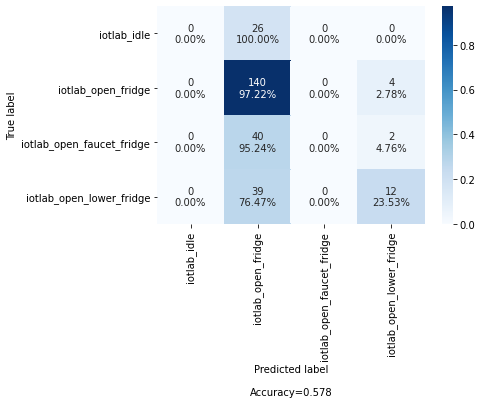

OvOSVC


OvOGP


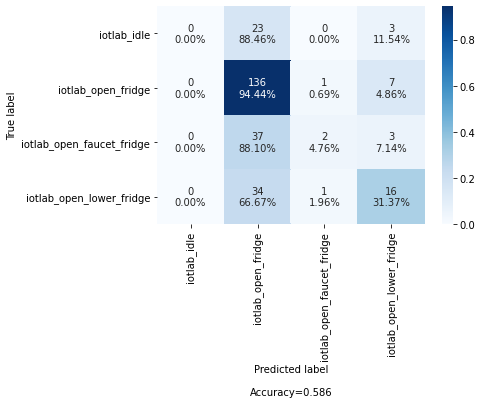

OvRLinearSVC


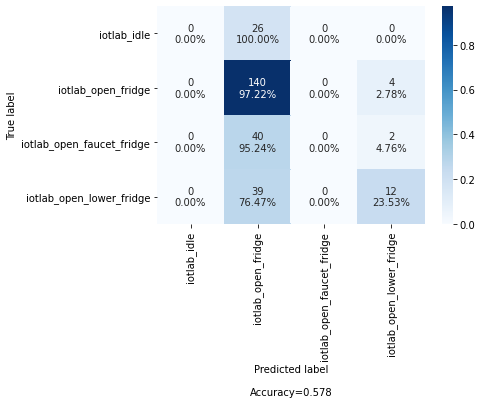

OvRLogReg


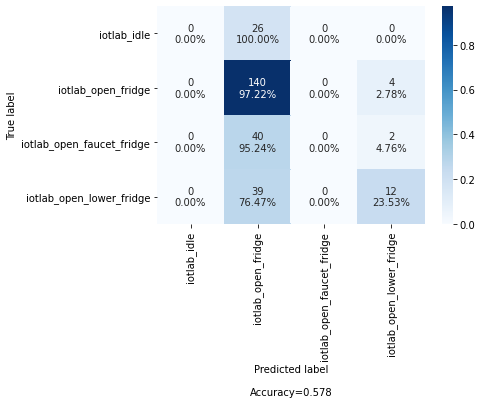

OvRGP


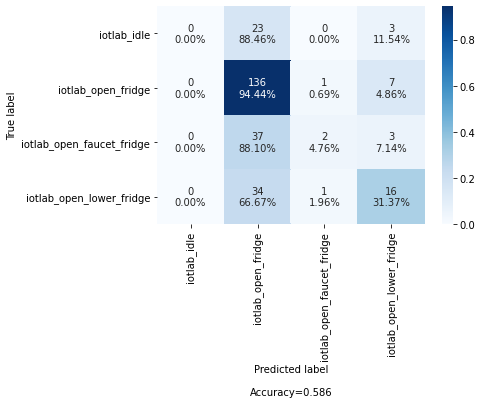

SIZE
DecTree


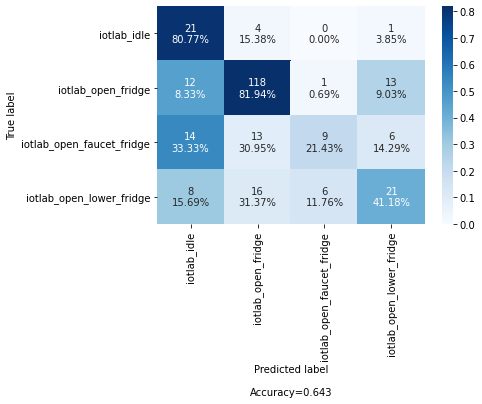

LogReg


OvOSVC


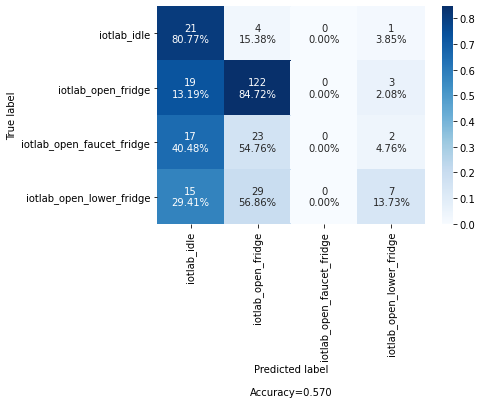

OvOGP


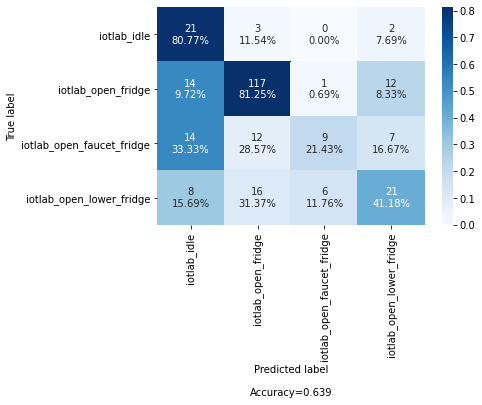

OvRLinearSVC


OvRLogReg


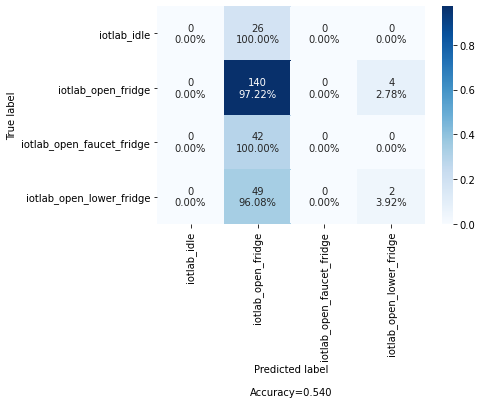

OvRGP


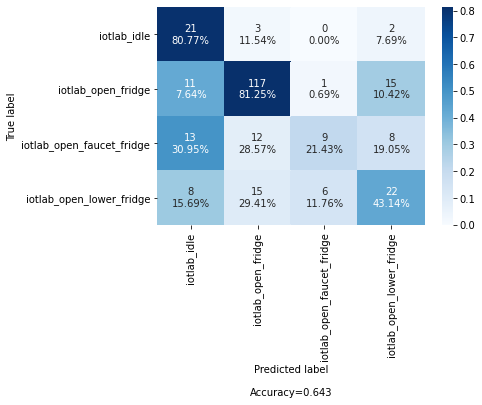

IAT_SIZE
DecTree


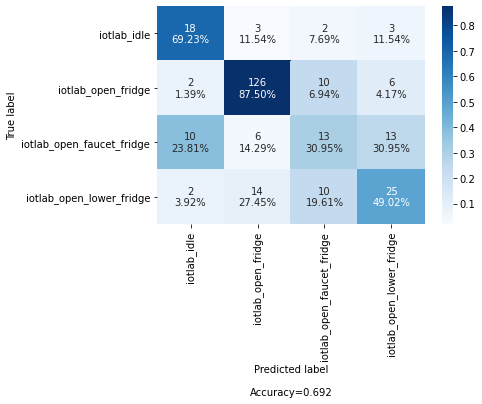

LogReg


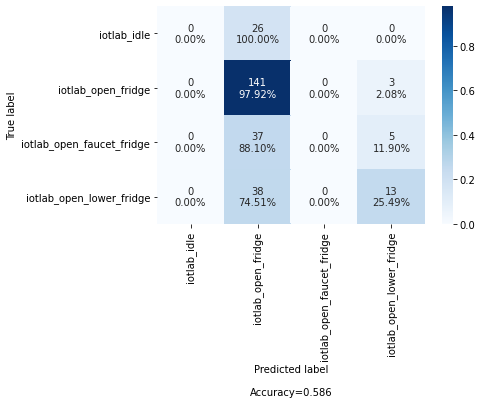

OvOSVC


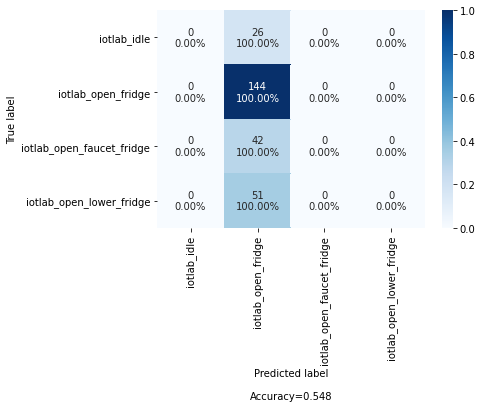

OvOGP


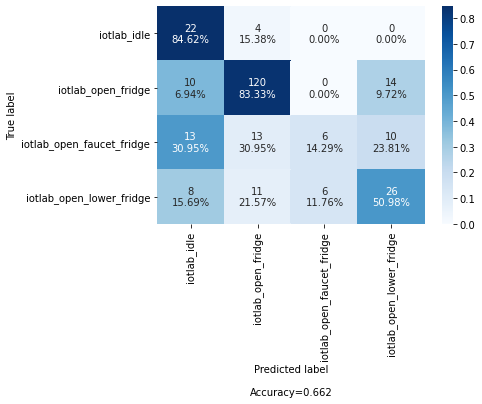

OvRLinearSVC


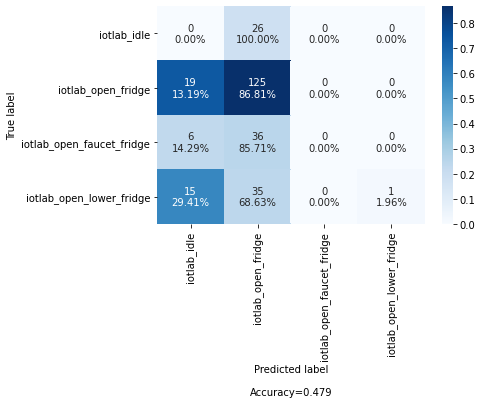

OvRLogReg


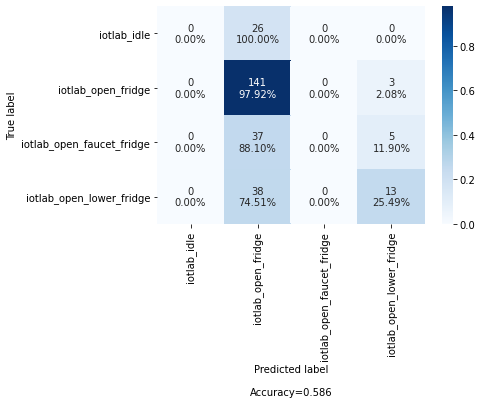

OvRGP


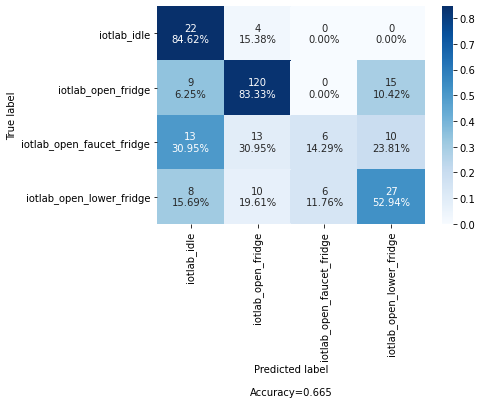

SAMP_NUM
DecTree


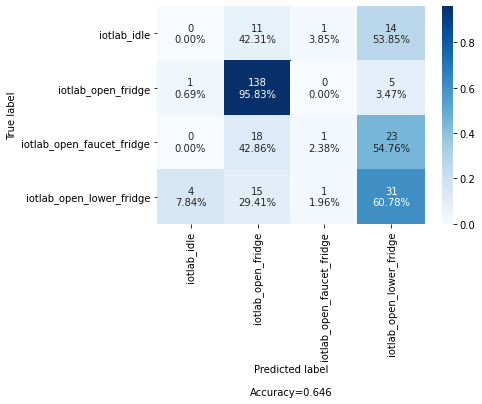

LogReg


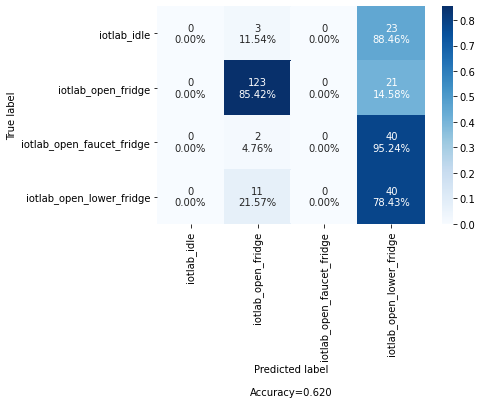

OvOSVC


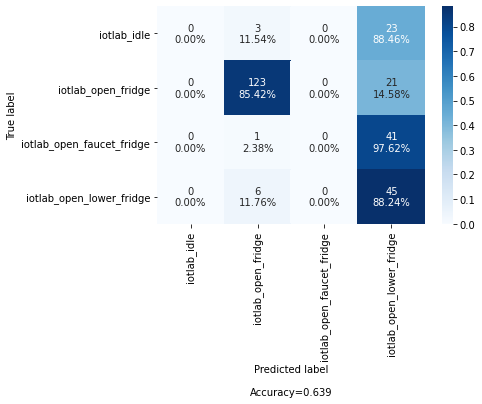

OvOGP


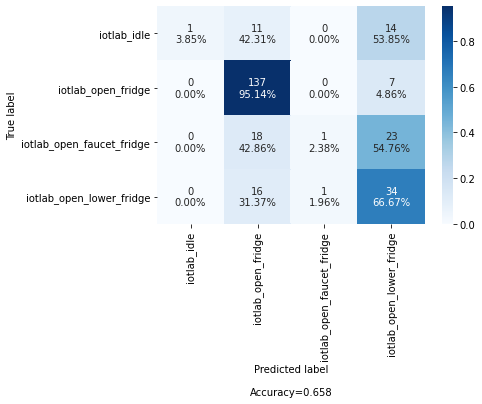

OvRLinearSVC


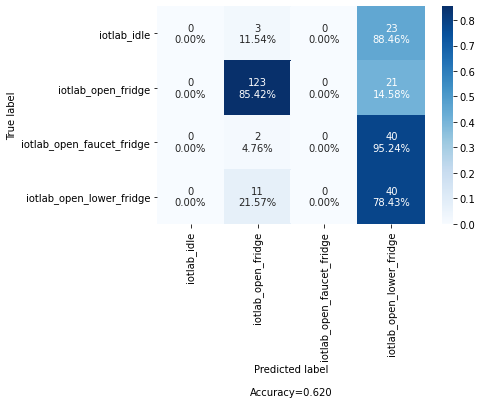

OvRLogReg


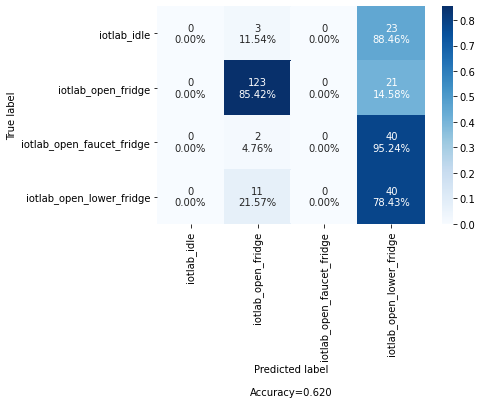

OvRGP


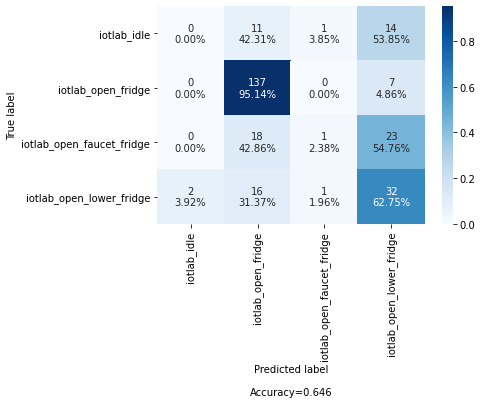

SAMP_SIZE
DecTree


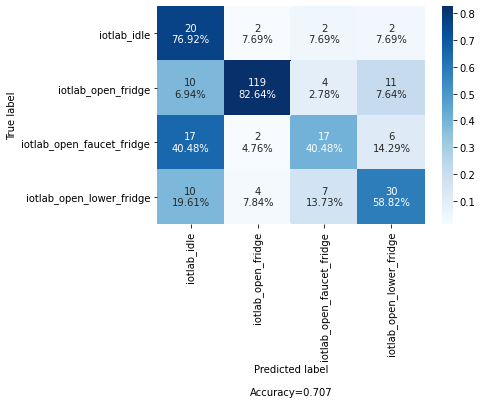

LogReg


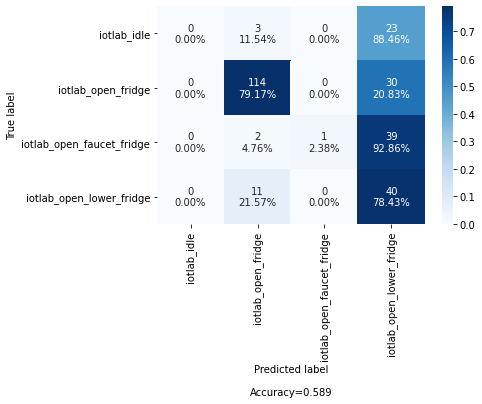

OvOSVC


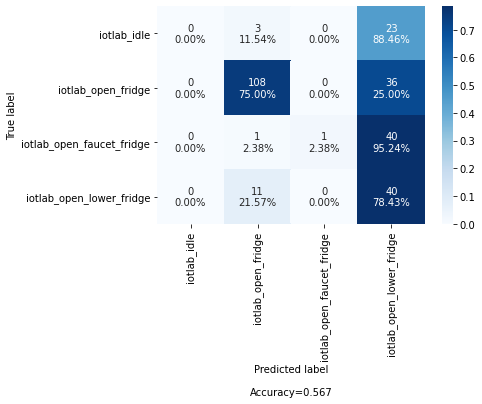

OvOGP


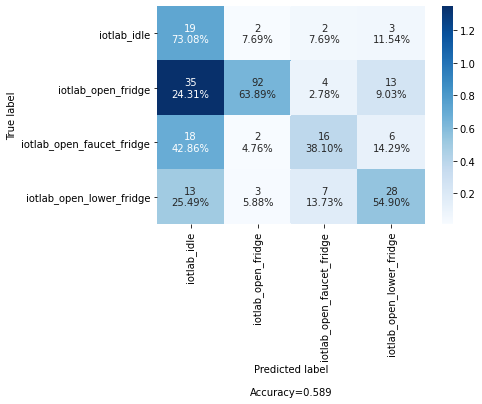

OvRLinearSVC


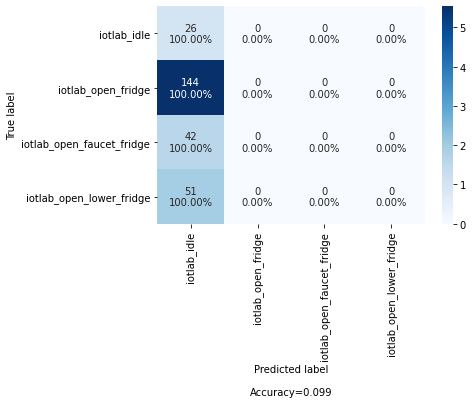

OvRLogReg


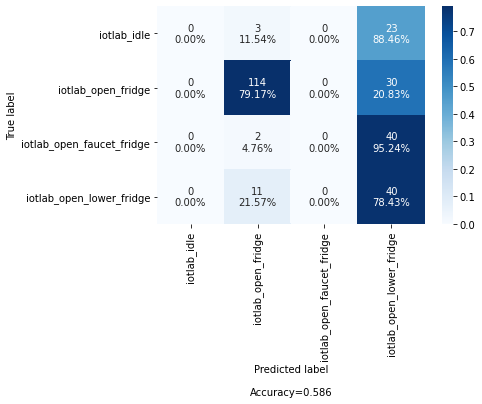

OvRGP


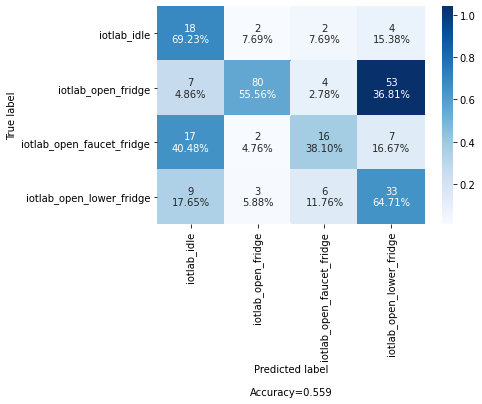

STATS
DecTree


LogReg


OvOSVC


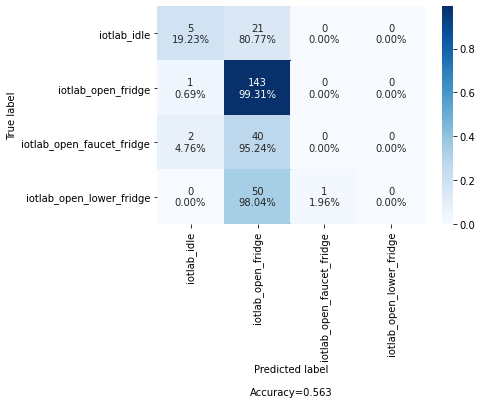

OvOGP


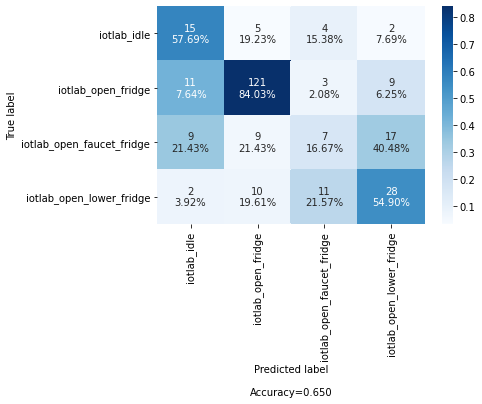

OvRLinearSVC


OvRLogReg


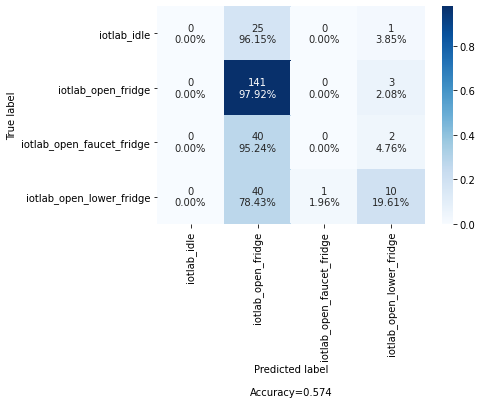

OvRGP


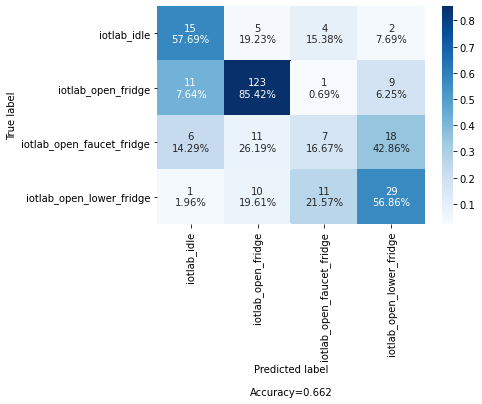

FFT-IAT
DecTree


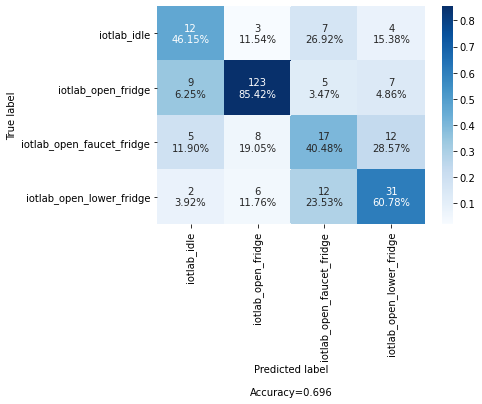

LogReg


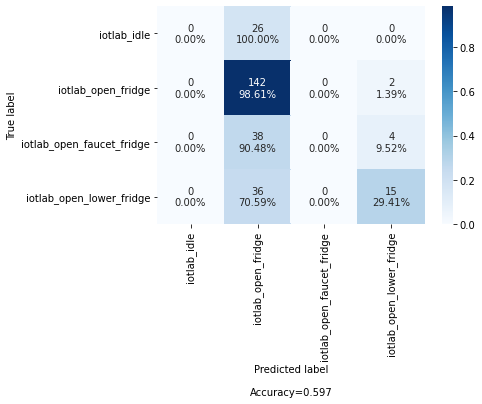

OvOSVC


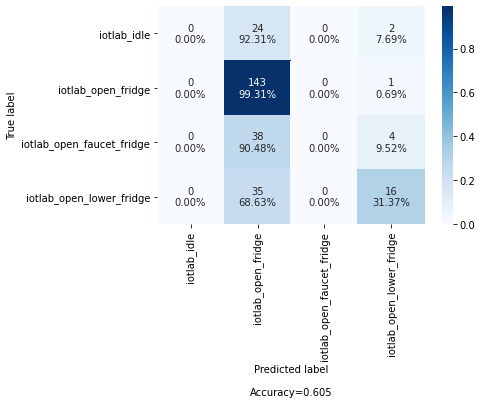

OvOGP


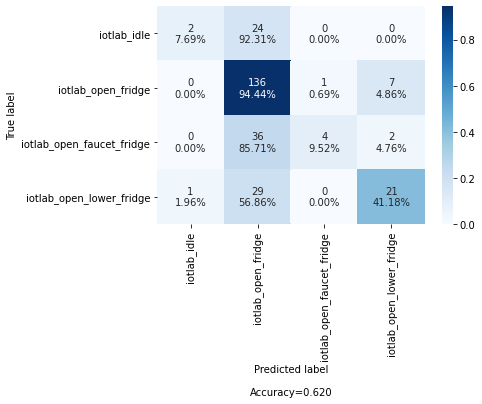

OvRLinearSVC


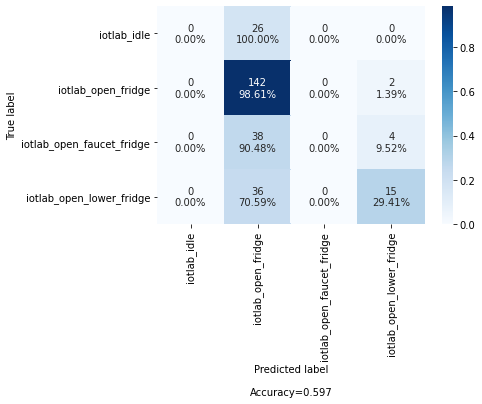

OvRLogReg


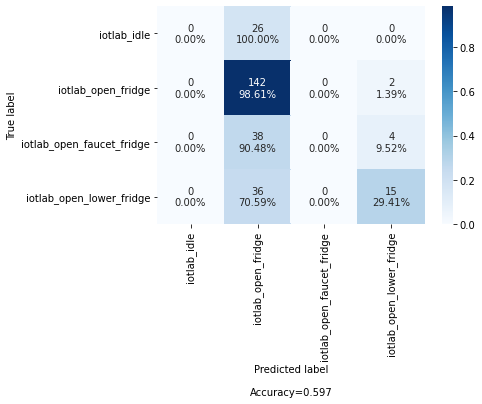

OvRGP


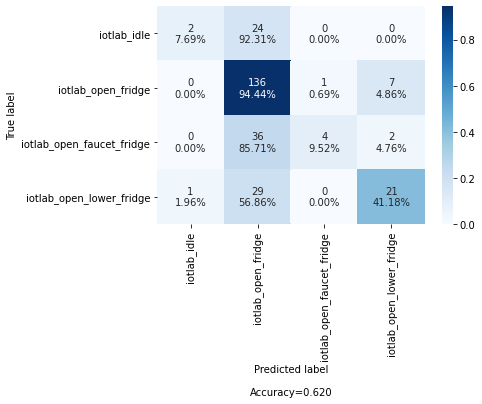

FFT-IAT_SIZE
DecTree


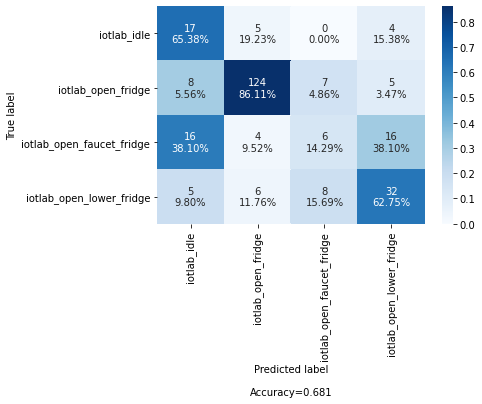

LogReg


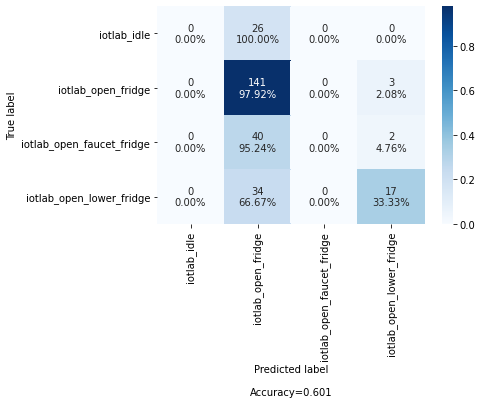

OvOSVC


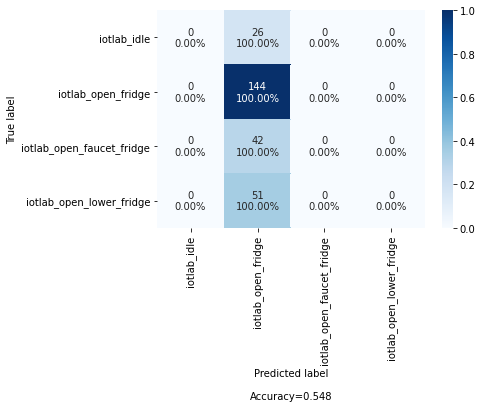

OvOGP


OvRLinearSVC


OvRLogReg


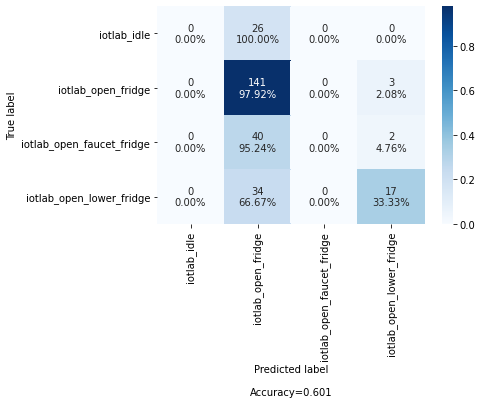

OvRGP


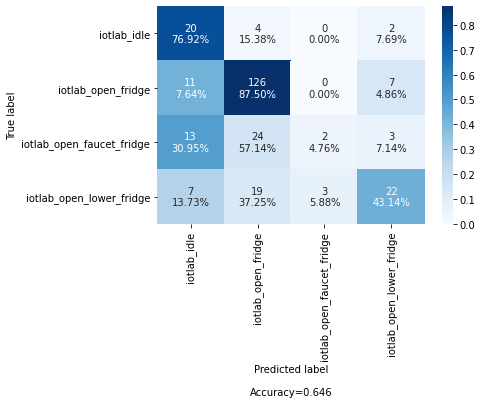

FFT-SIZE
DecTree


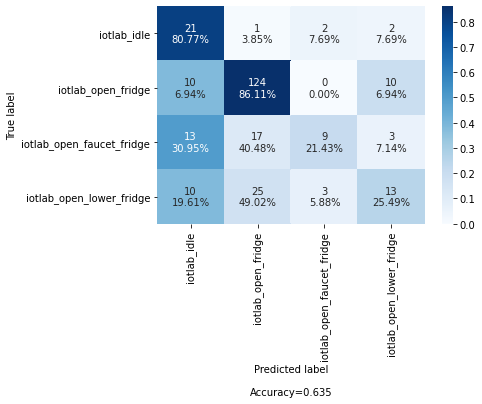

LogReg


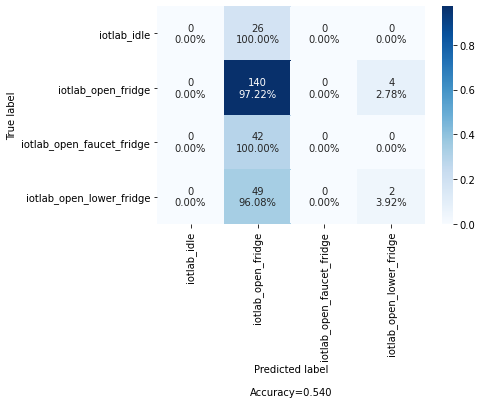

OvOSVC


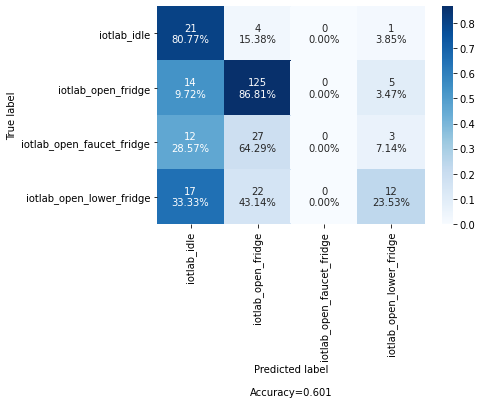

OvOGP


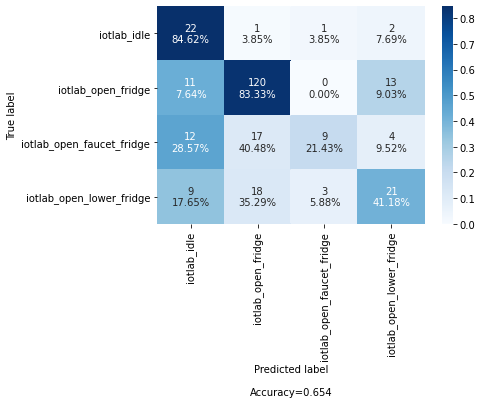

OvRLinearSVC


OvRLogReg


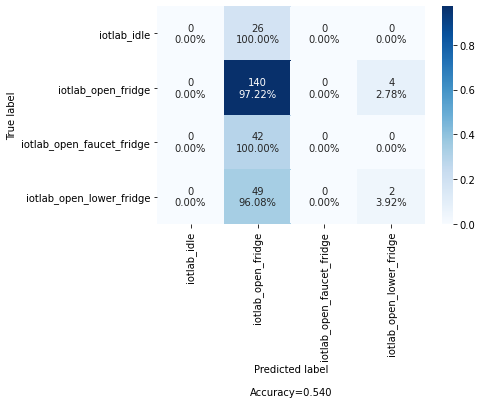

OvRGP


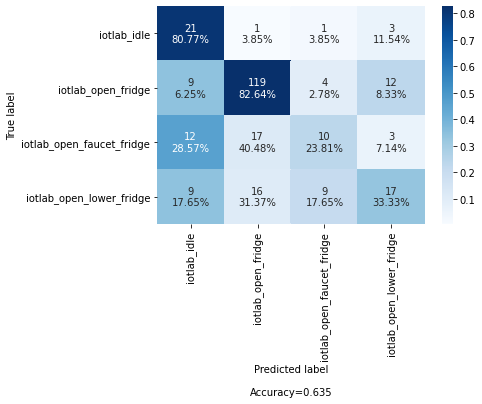

FFT-SAMP_NUM
DecTree


LogReg


OvOSVC


OvOGP


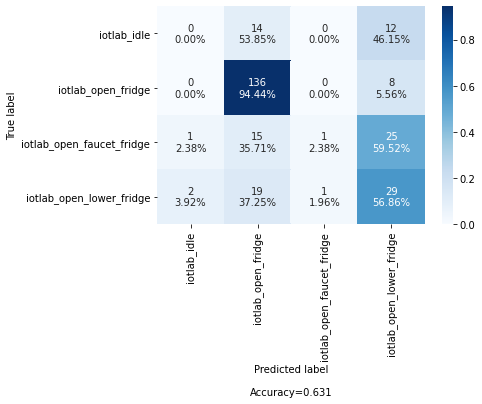

OvRLinearSVC


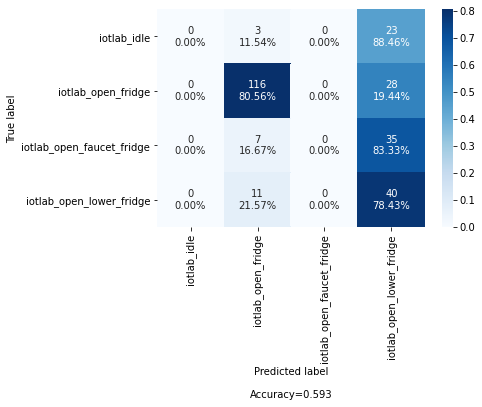

OvRLogReg


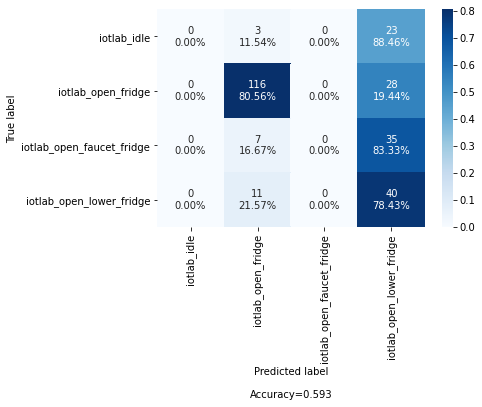

OvRGP


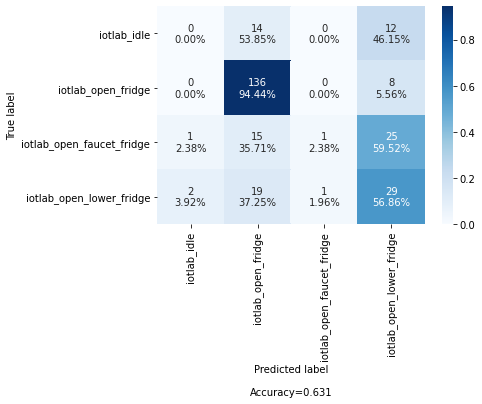

FFT-SAMP_SIZE
DecTree


LogReg


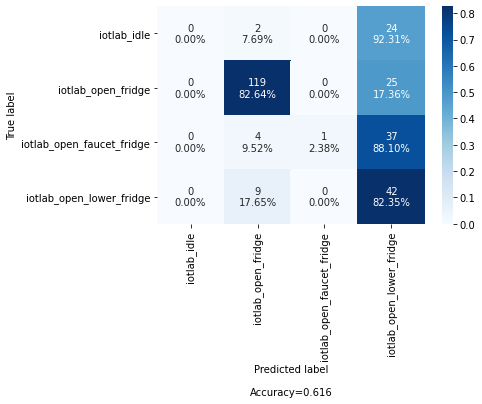

OvOSVC


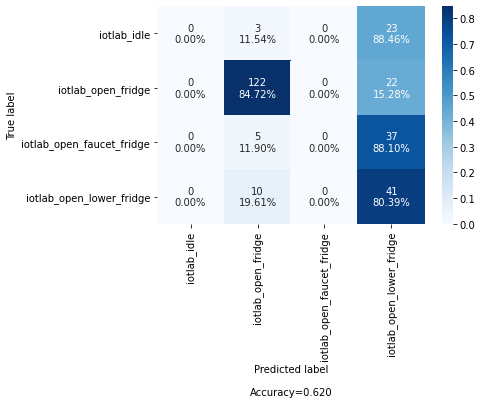

OvOGP


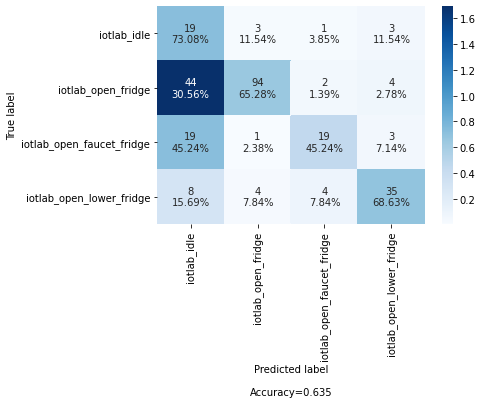

OvRLinearSVC


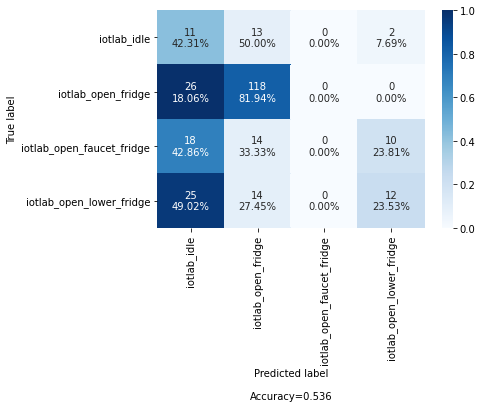

OvRLogReg


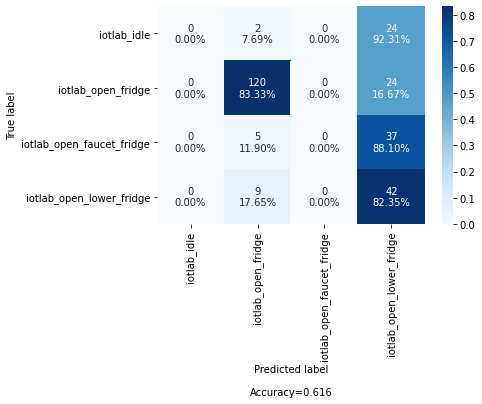

OvRGP


In [108]:
feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat)

keypoint
['../../features/iotlab_idle/keypoint/fridge-keypoint_29.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_15.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_14.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_28.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_16.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_17.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_13.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_12.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_10.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_38.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_39.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_11.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_49.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_61.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_60.dat', '../../features/iotlab_idle/keypoint/fridge-keypoint_48.dat'

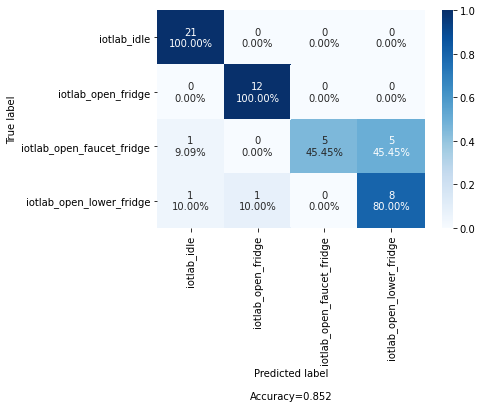

LogReg


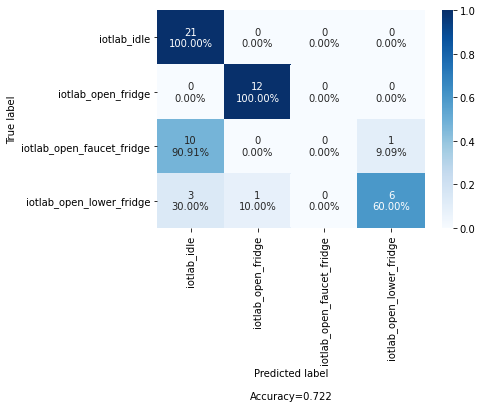

OvOSVC


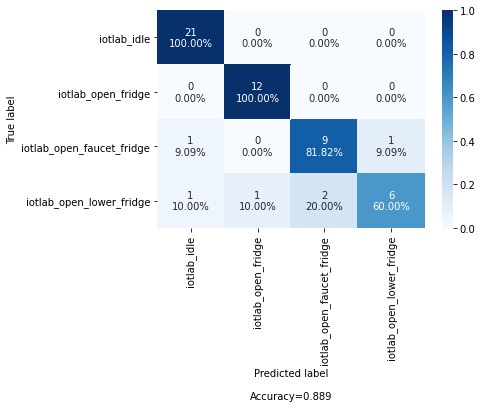

OvOGP


OvRLinearSVC


OvRLogReg


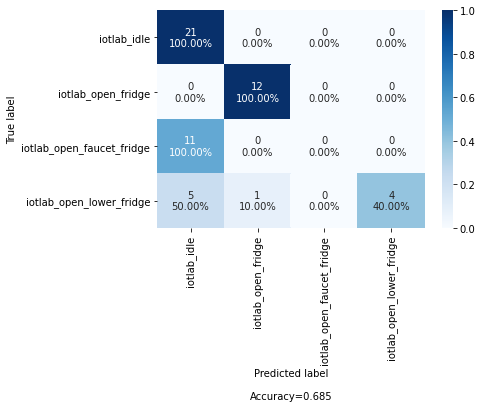

OvRGP


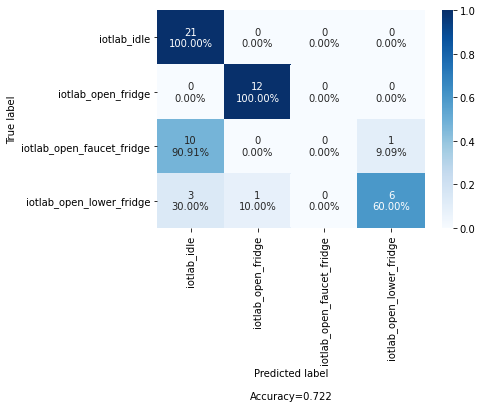

In [32]:
# Only consider keypoints 
feat_types = ['keypoint']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat)

IAT
DecTree


LogReg


OvOSVC


OvOGP


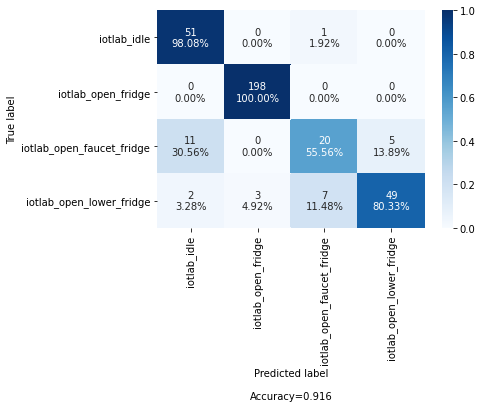

OvRLinearSVC


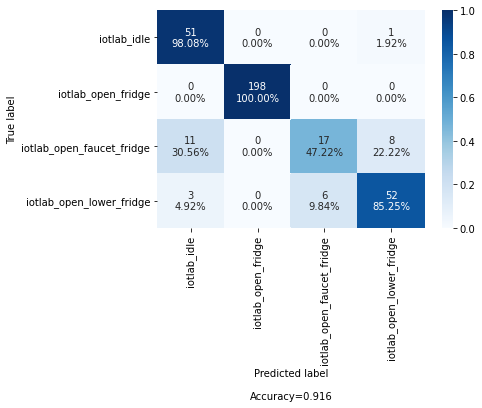

OvRLogReg


OvRGP


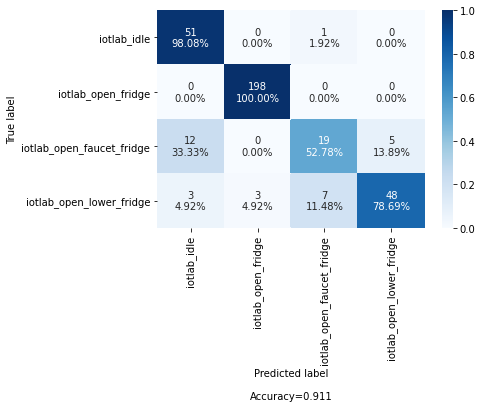

SIZE
DecTree


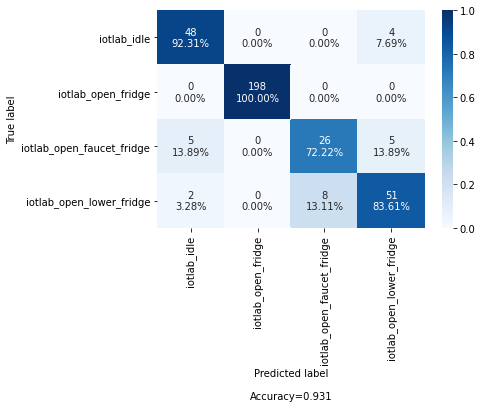

LogReg


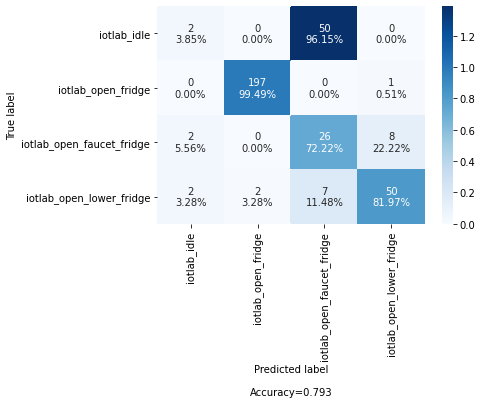

OvOSVC


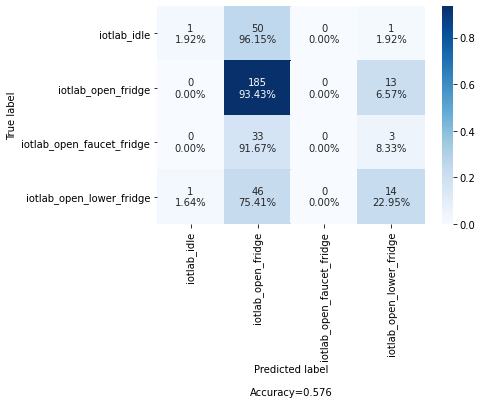

OvOGP


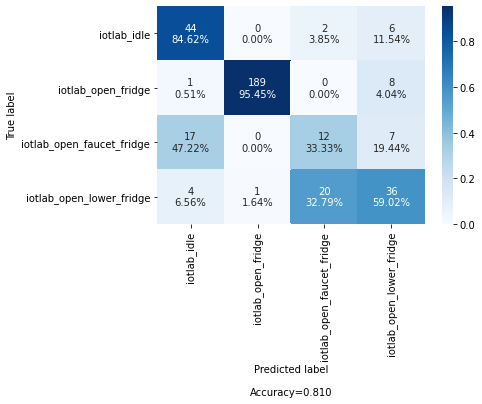

OvRLinearSVC


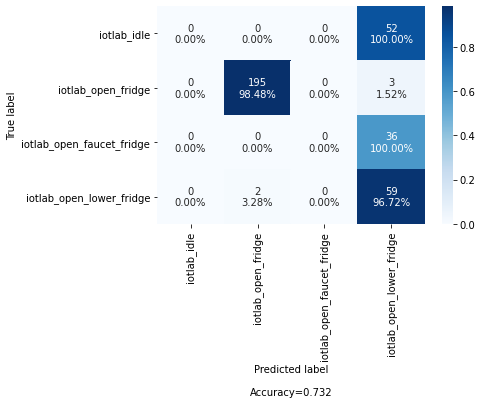

OvRLogReg


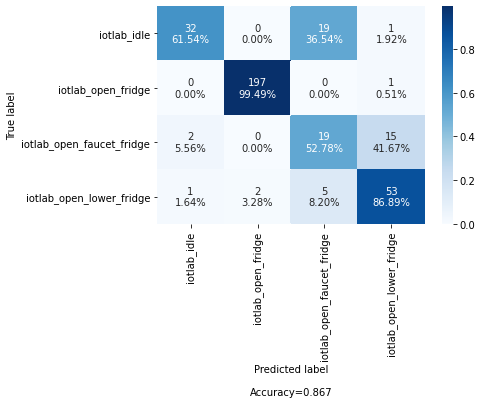

OvRGP


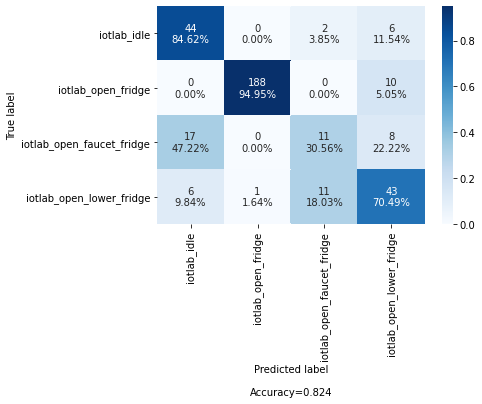

IAT_SIZE
DecTree


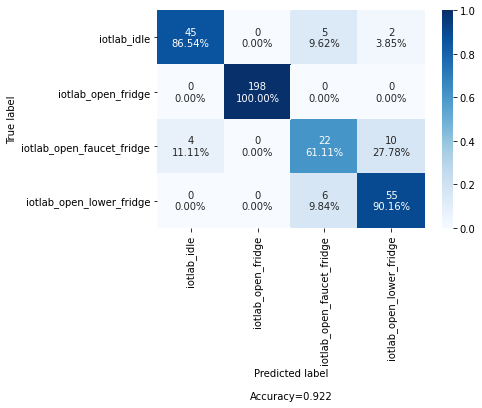

LogReg


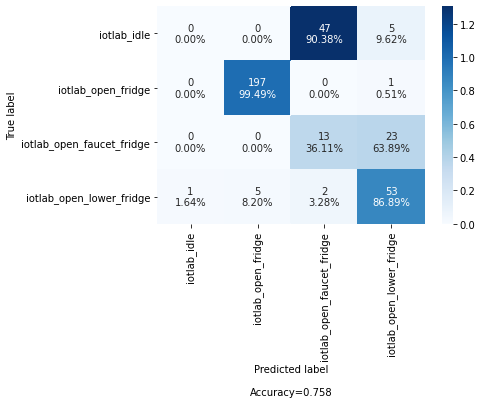

OvOSVC


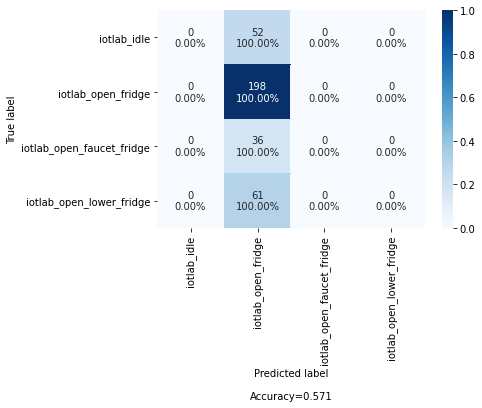

OvOGP


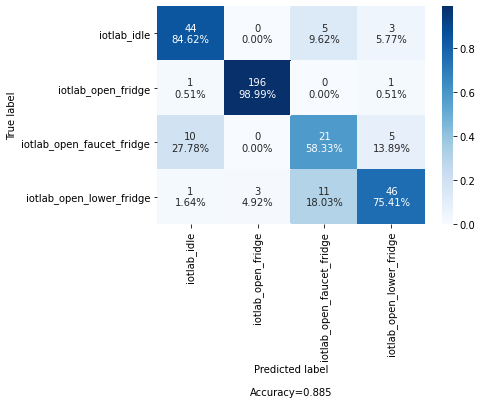

OvRLinearSVC


OvRLogReg


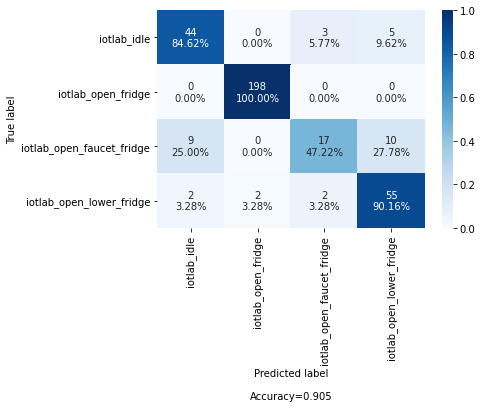

OvRGP


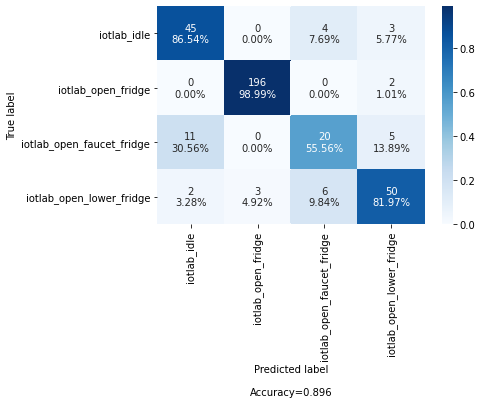

SAMP_NUM
DecTree


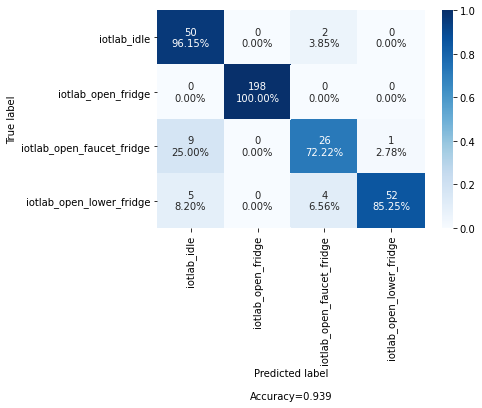

LogReg


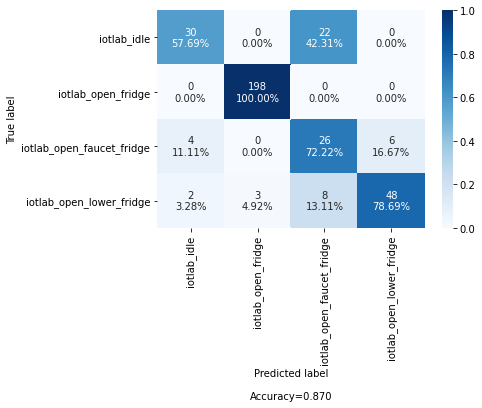

OvOSVC


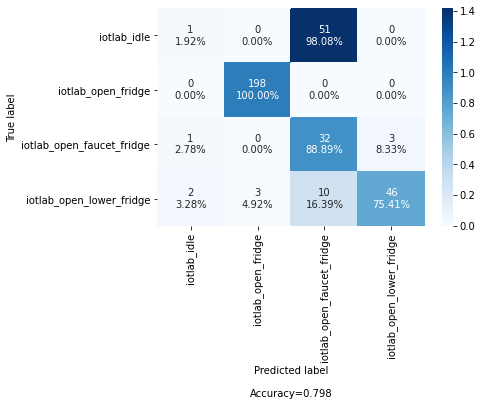

OvOGP


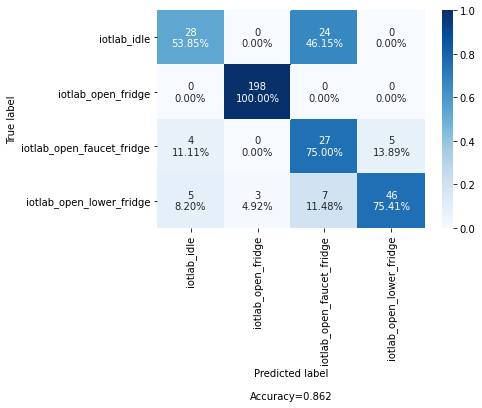

OvRLinearSVC


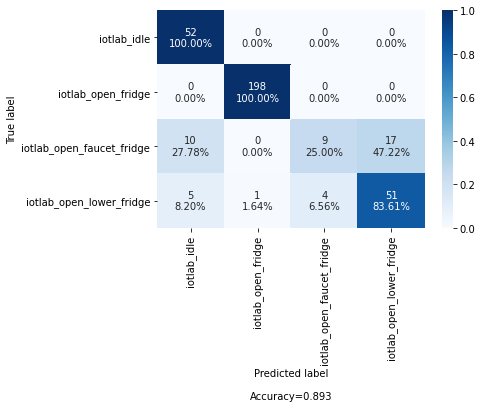

OvRLogReg


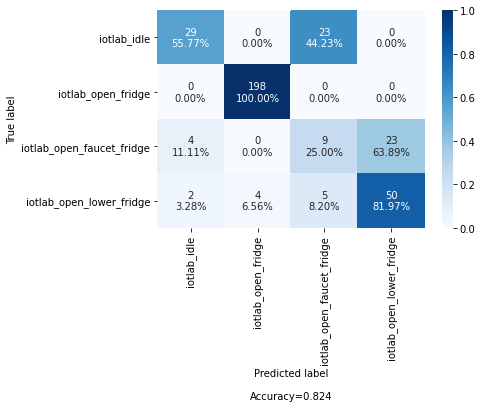

OvRGP


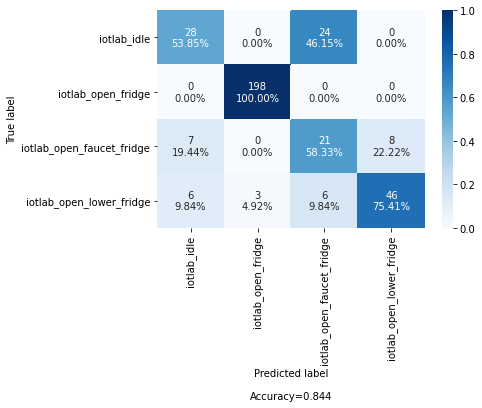

SAMP_SIZE
DecTree


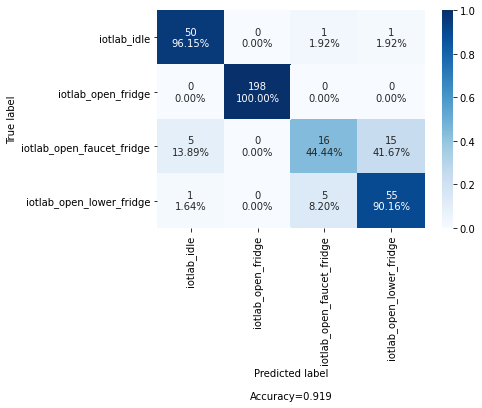

LogReg


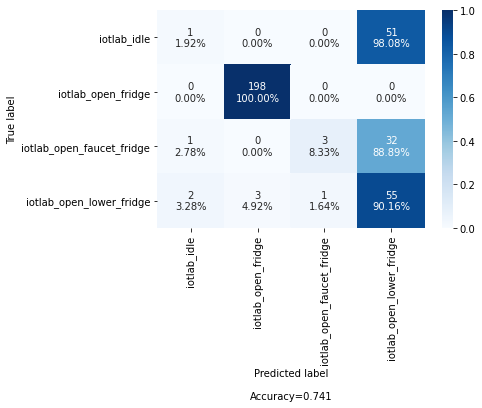

OvOSVC


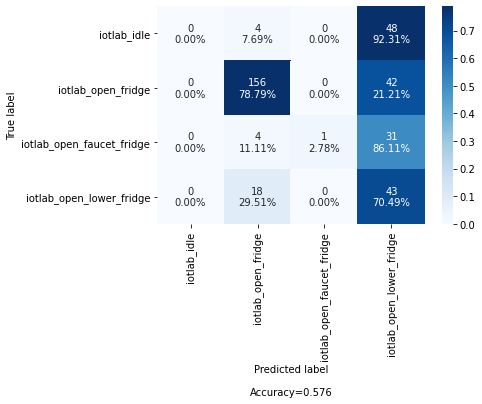

OvOGP


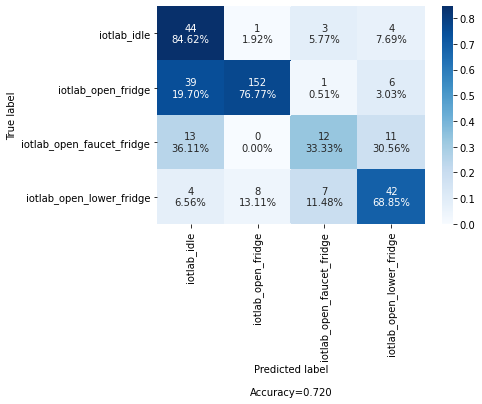

OvRLinearSVC


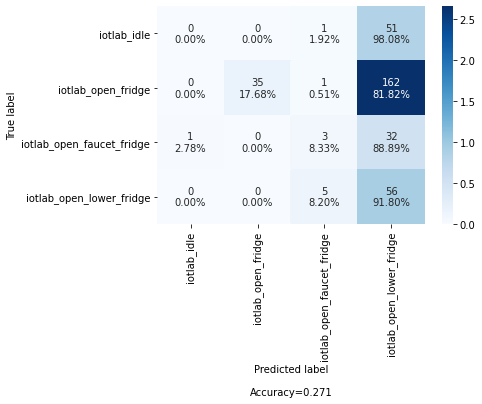

OvRLogReg


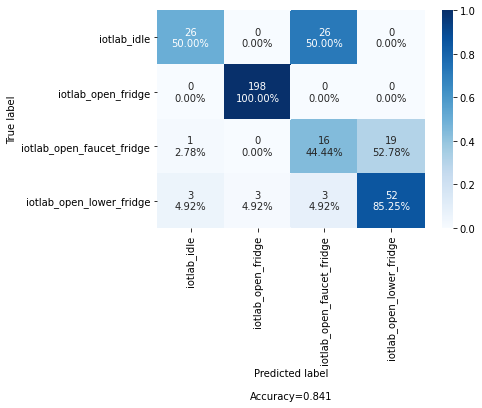

OvRGP


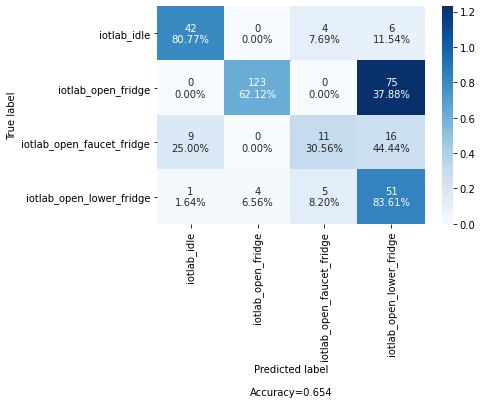

STATS
DecTree


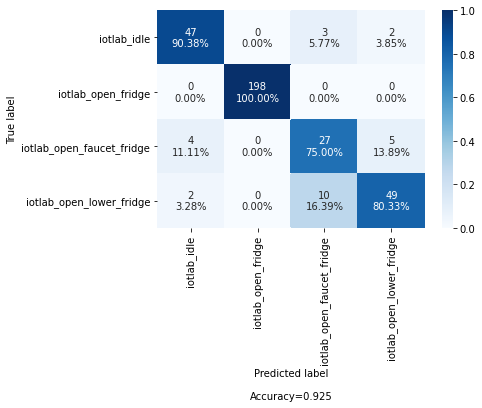

LogReg


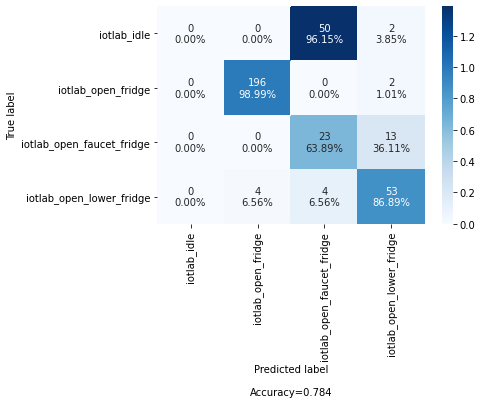

OvOSVC


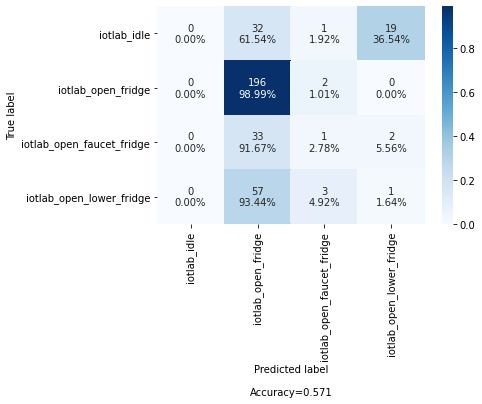

OvOGP


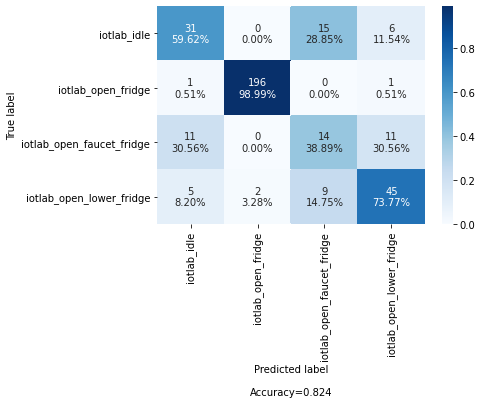

OvRLinearSVC


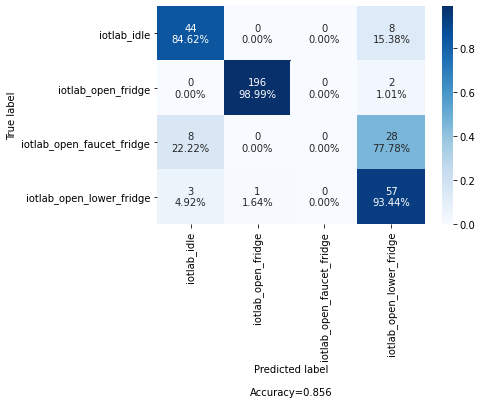

OvRLogReg


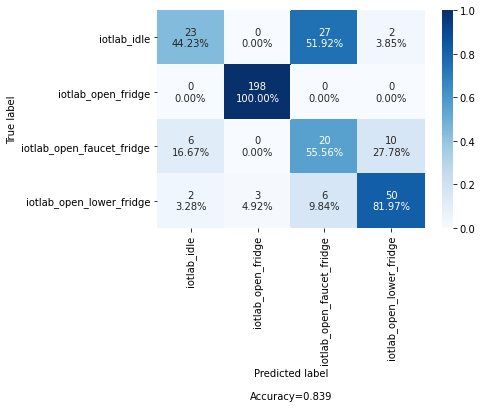

OvRGP


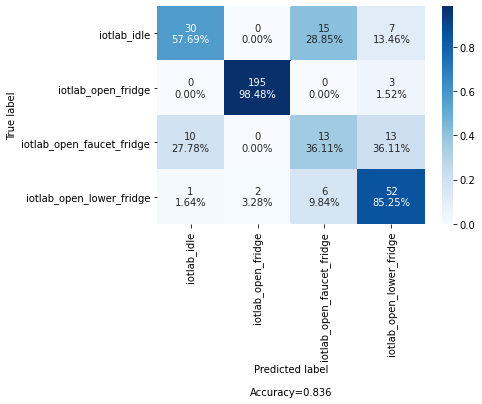

FFT-IAT
DecTree


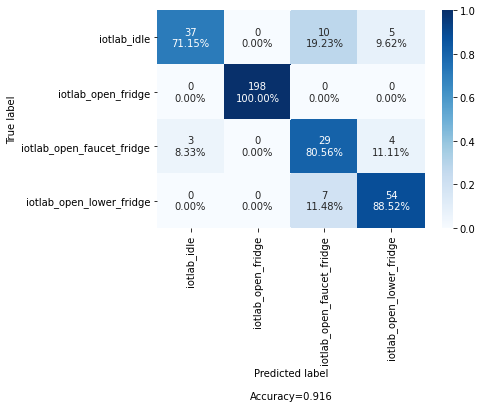

LogReg


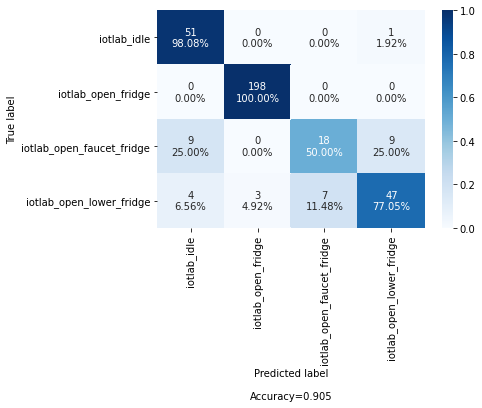

OvOSVC


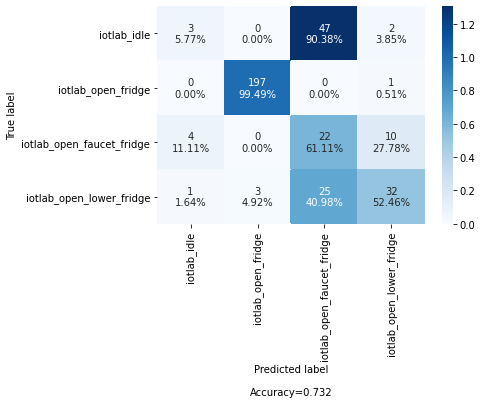

OvOGP


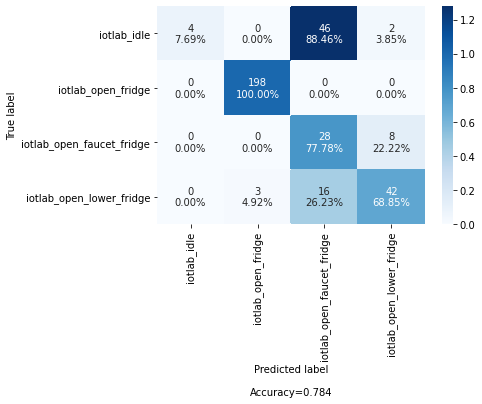

OvRLinearSVC


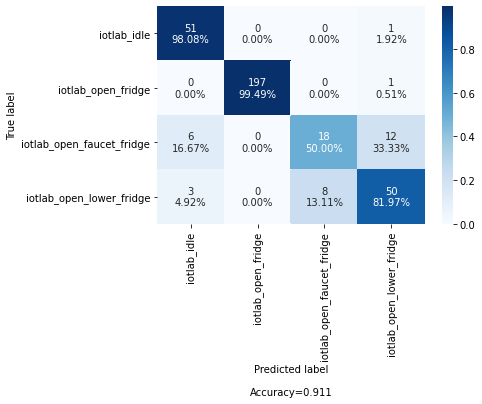

OvRLogReg


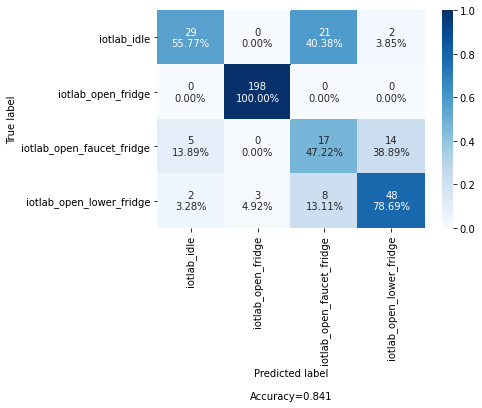

OvRGP


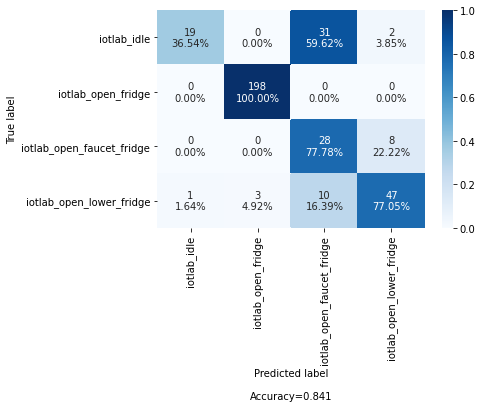

FFT-IAT_SIZE
DecTree


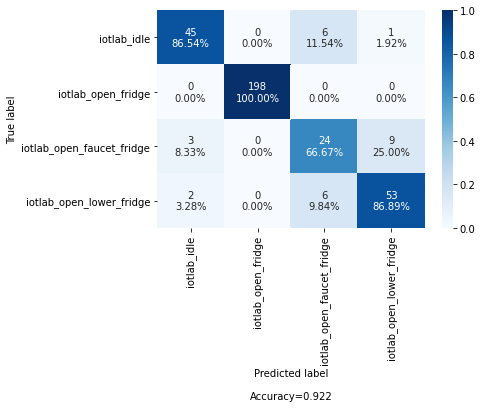

LogReg


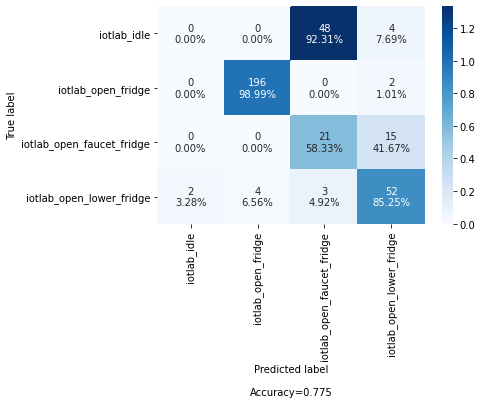

OvOSVC


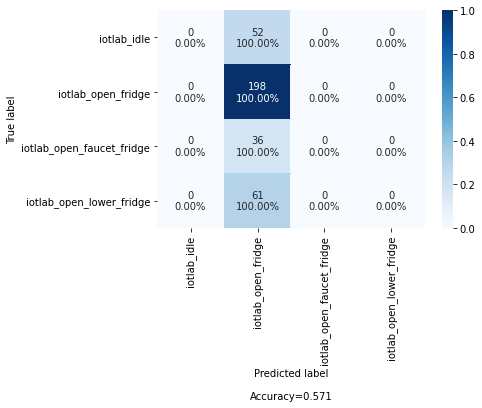

OvOGP


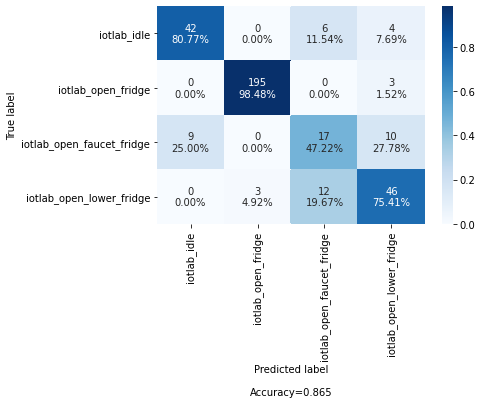

OvRLinearSVC


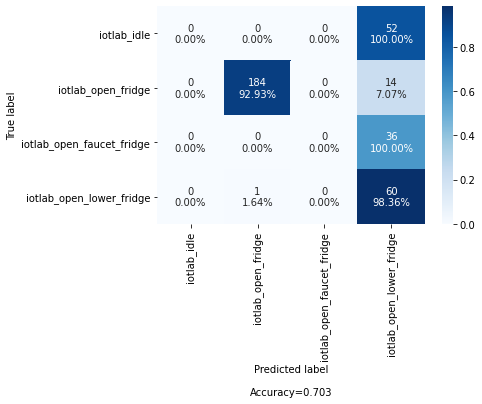

OvRLogReg


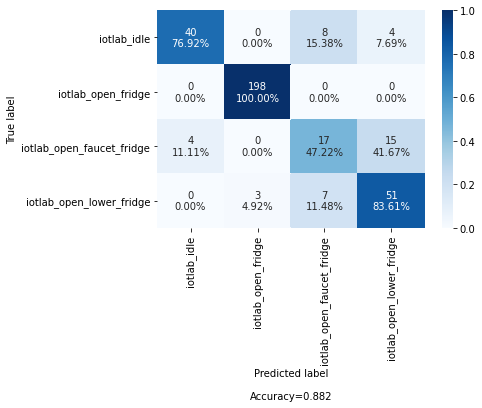

OvRGP


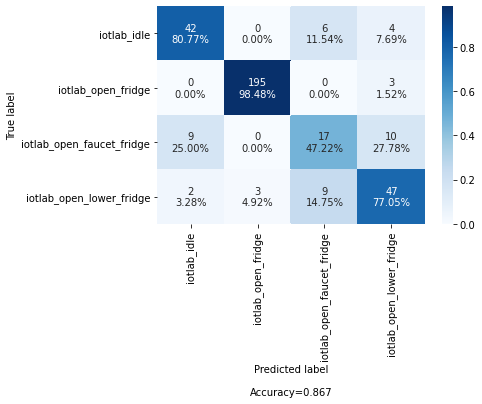

FFT-SIZE
DecTree


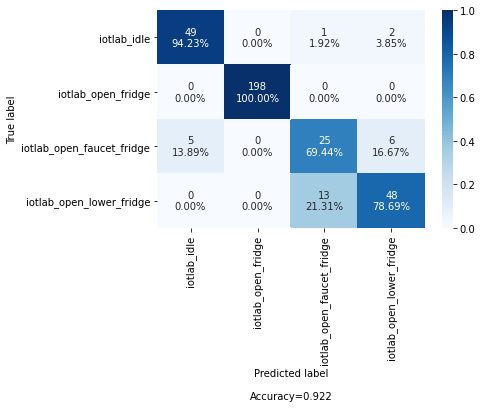

LogReg


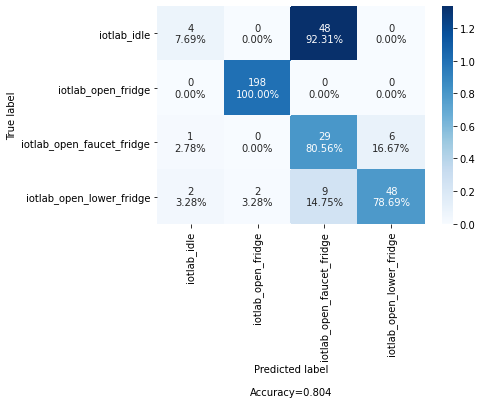

OvOSVC


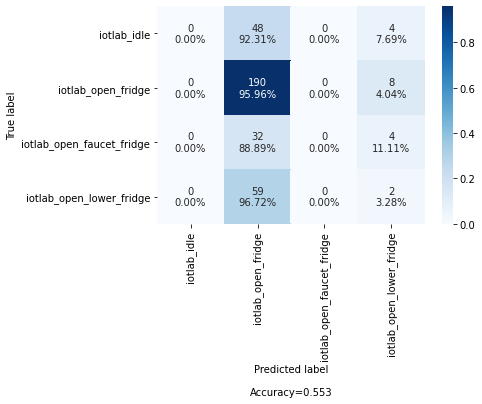

OvOGP


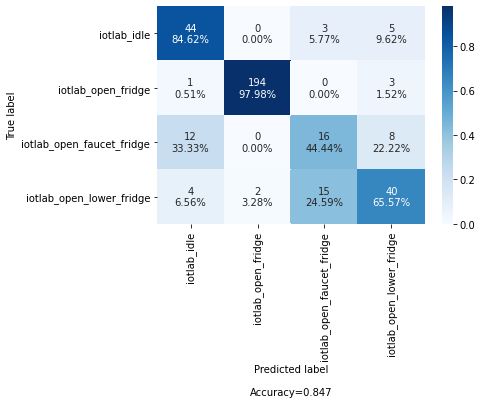

OvRLinearSVC


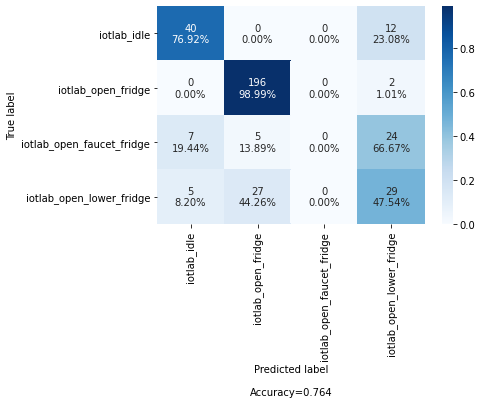

OvRLogReg


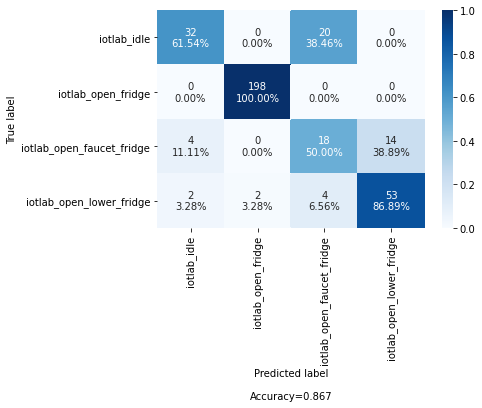

OvRGP


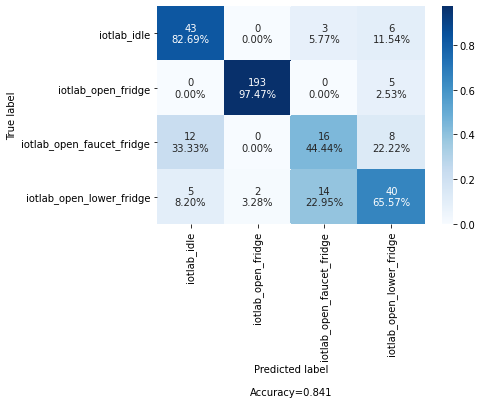

FFT-SAMP_NUM
DecTree


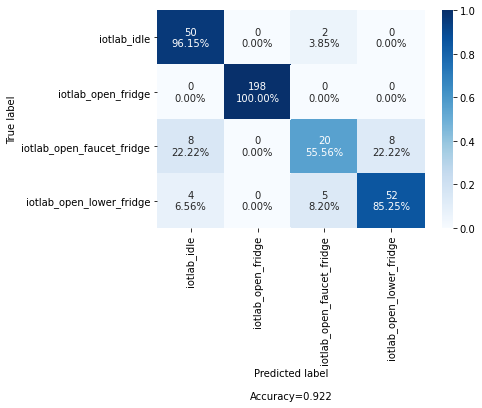

LogReg


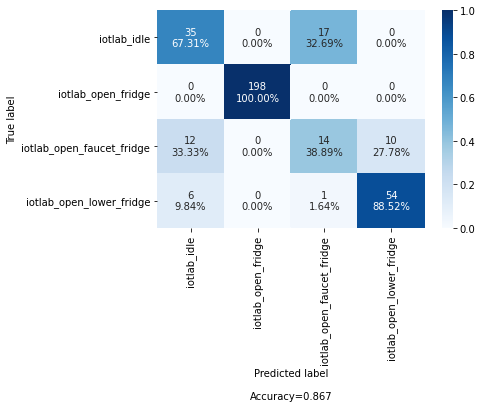

OvOSVC


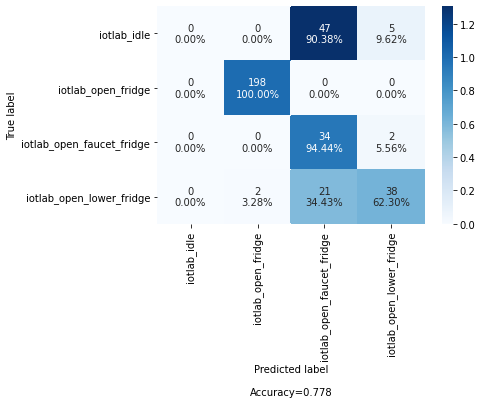

OvOGP


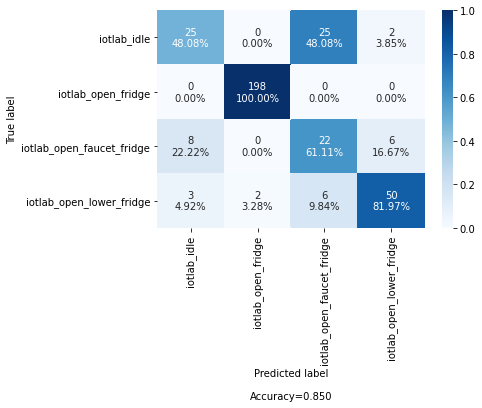

OvRLinearSVC


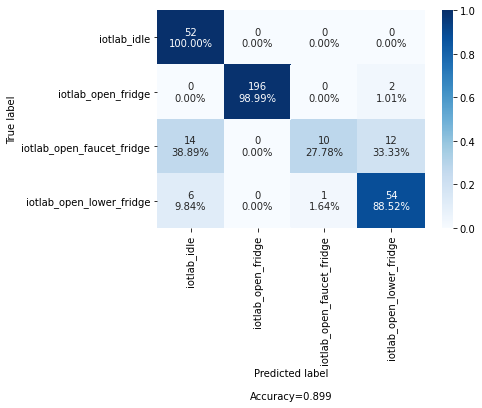

OvRLogReg


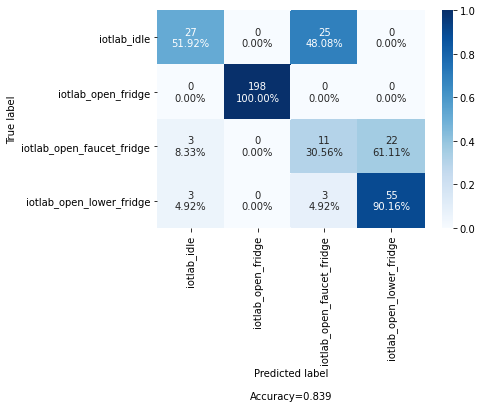

OvRGP


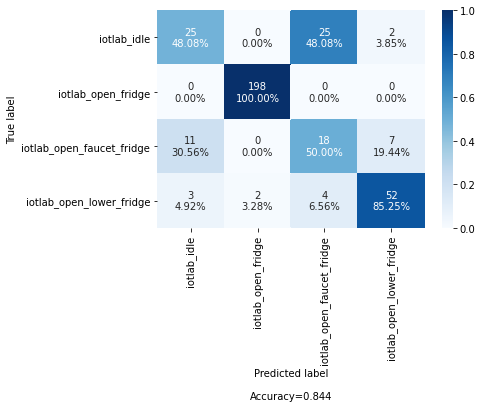

FFT-SAMP_SIZE
DecTree


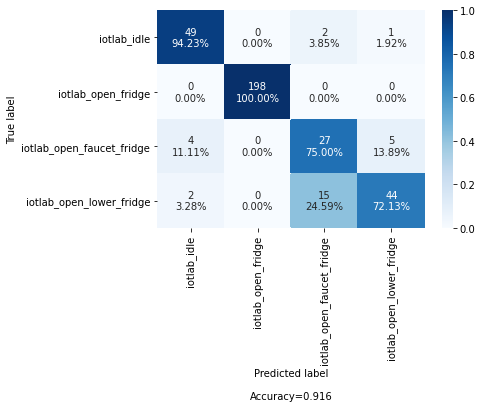

LogReg


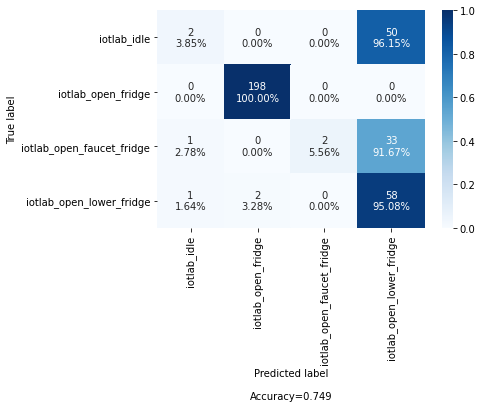

OvOSVC


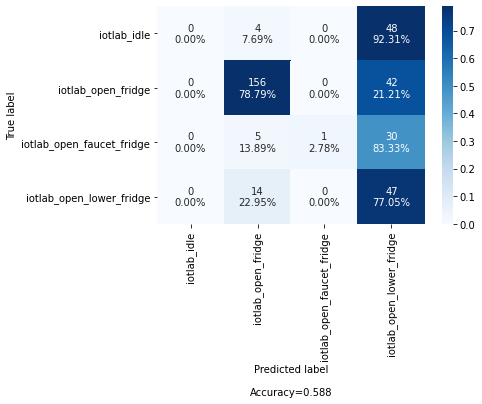

OvOGP


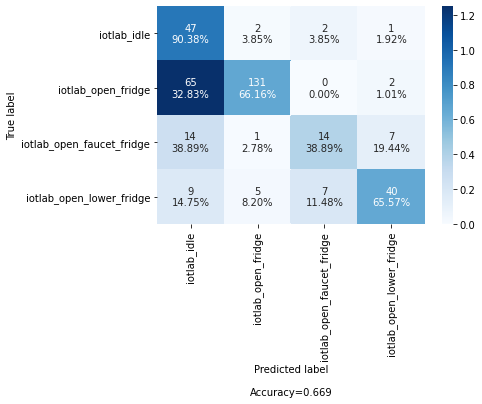

OvRLinearSVC


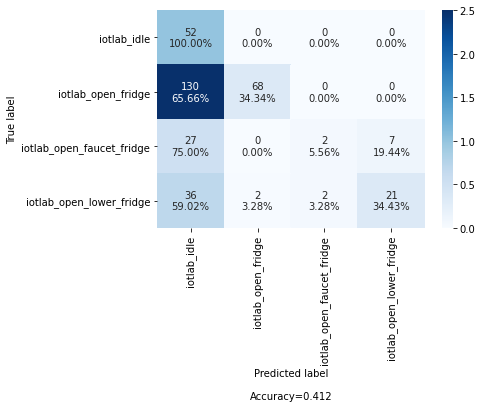

OvRLogReg


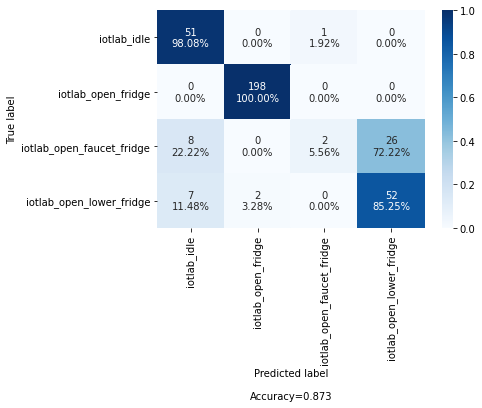

OvRGP


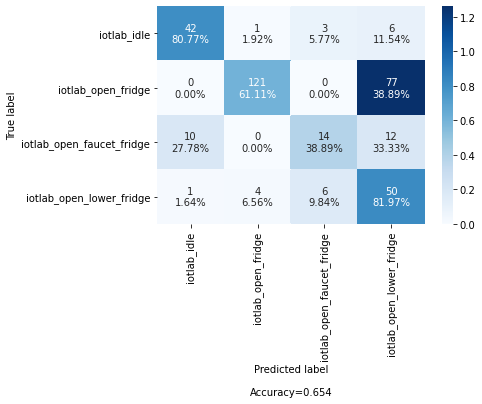

In [21]:
# consider keypoint features
feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat)

IAT
DecTree


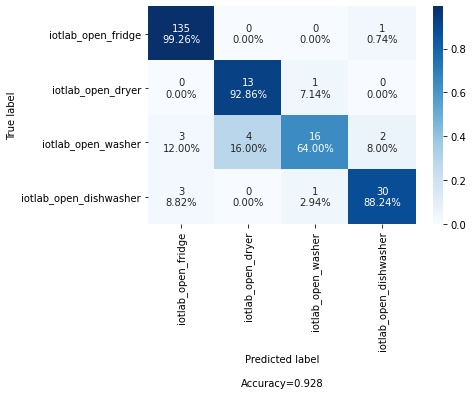

LogReg


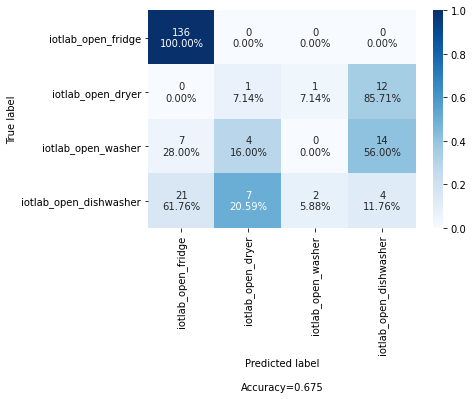

OvOSVC


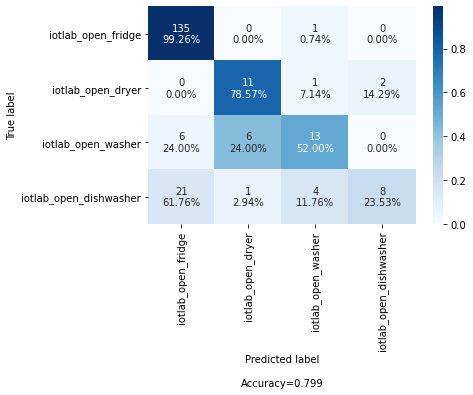

OvOGP


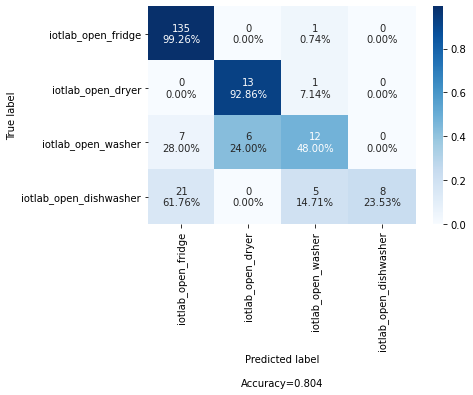

OvRLinearSVC


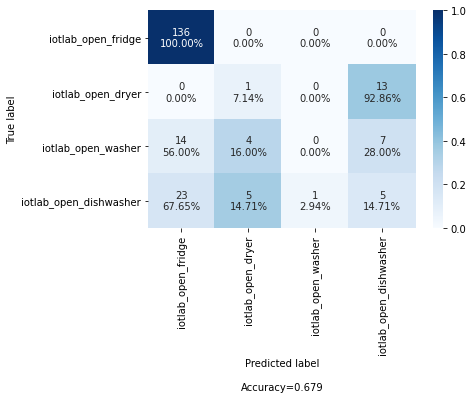

OvRLogReg


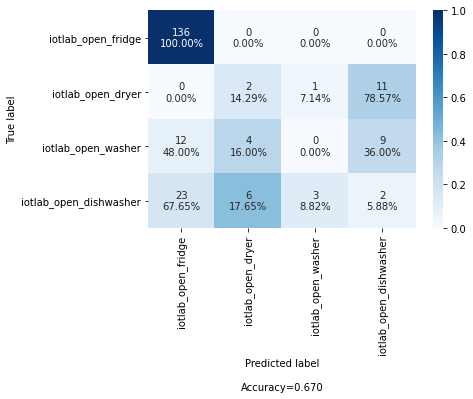

OvRGP


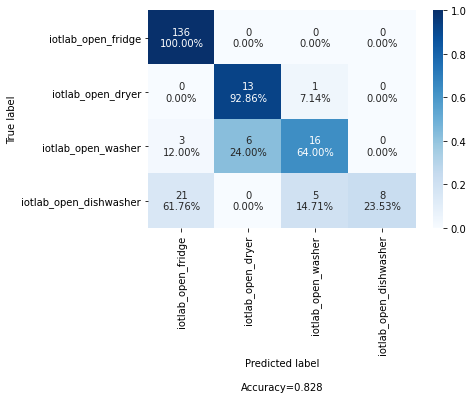

SIZE
DecTree


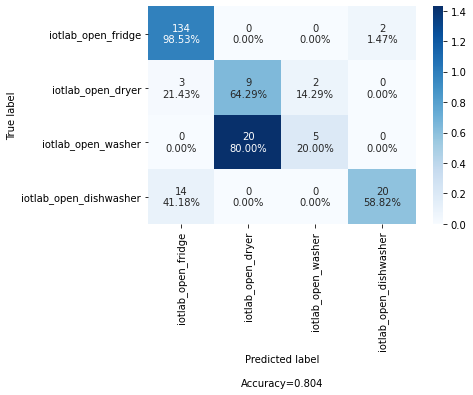

LogReg


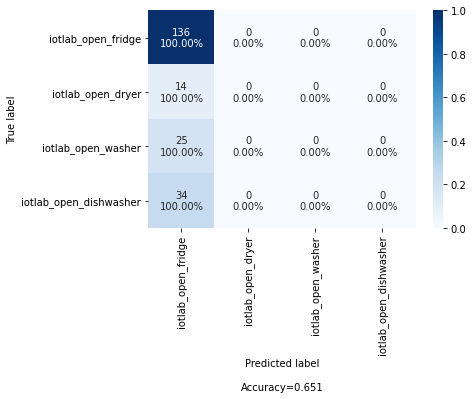

OvOSVC


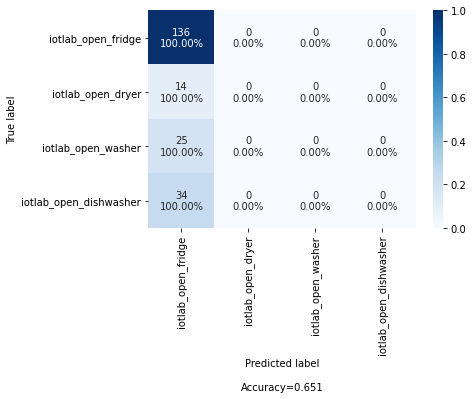

OvOGP


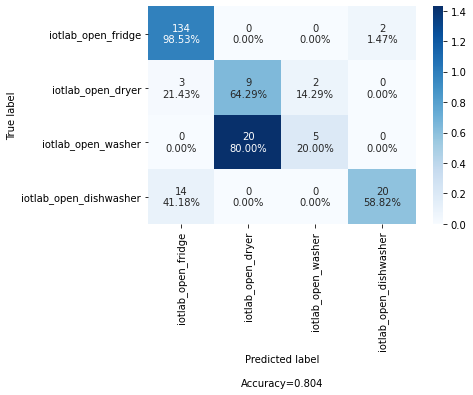

OvRLinearSVC


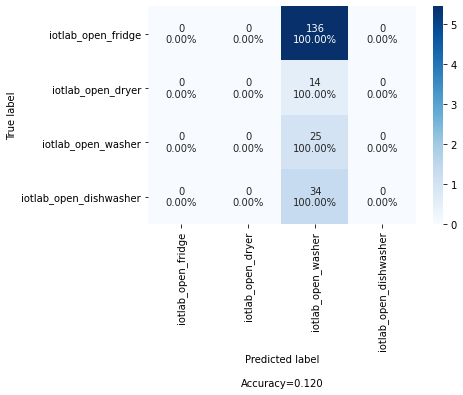

OvRLogReg


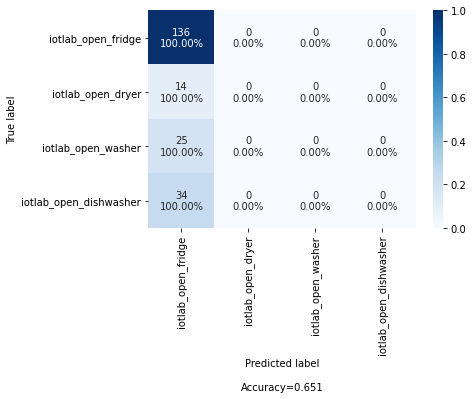

OvRGP


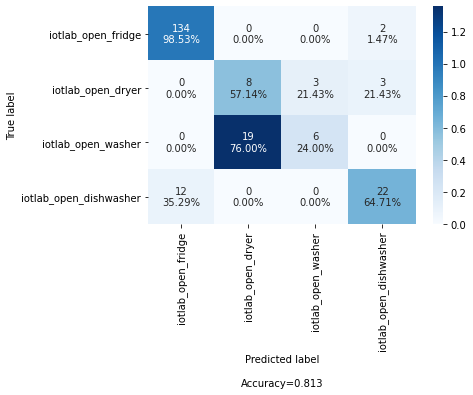

IAT_SIZE
DecTree


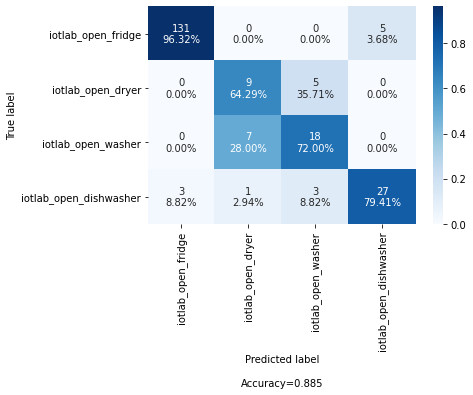

LogReg


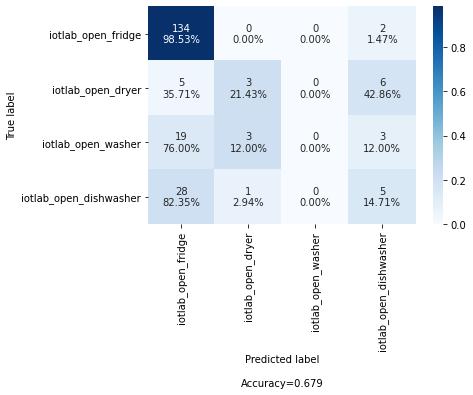

OvOSVC


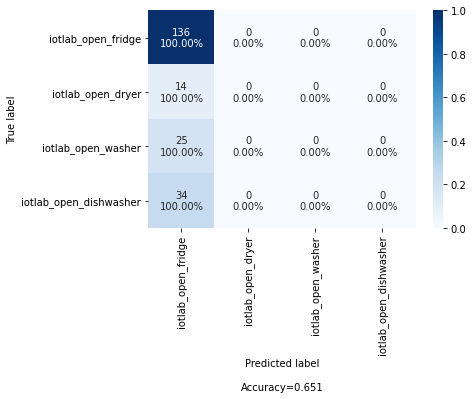

OvOGP


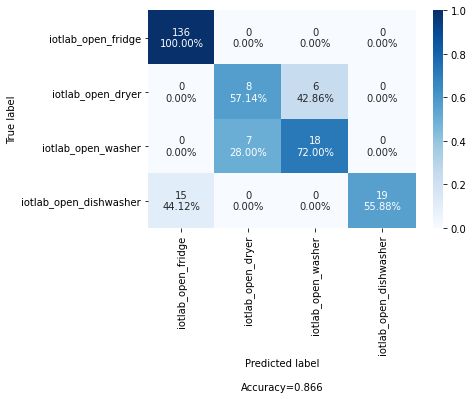

OvRLinearSVC


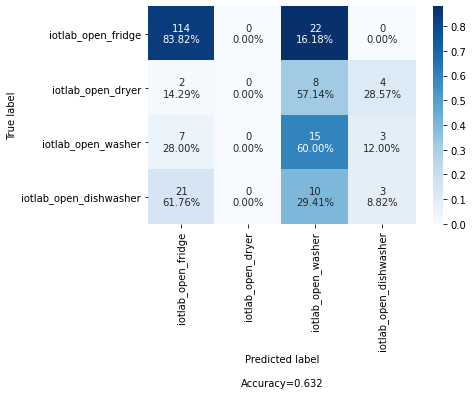

OvRLogReg


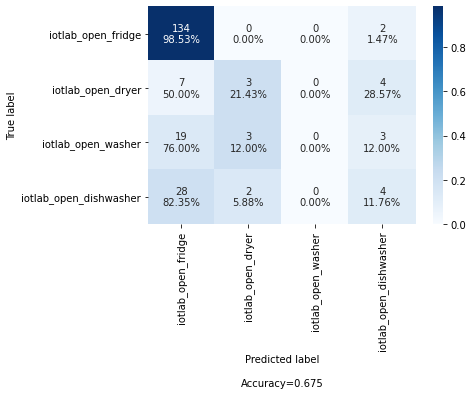

OvRGP


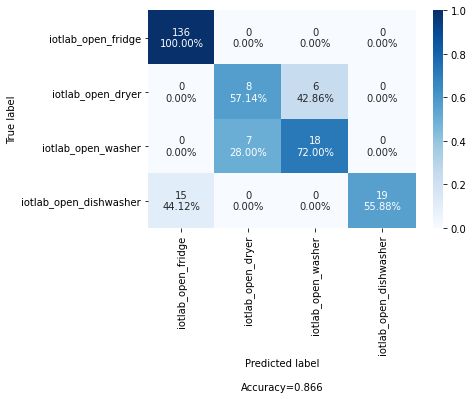

SAMP_NUM
DecTree


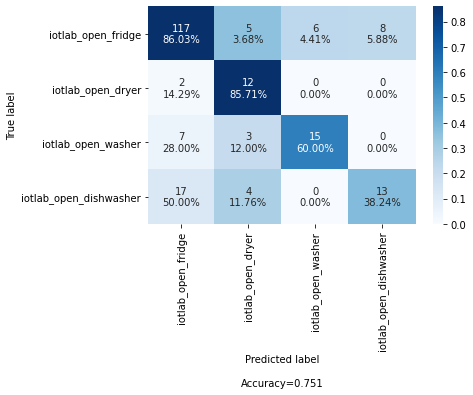

LogReg


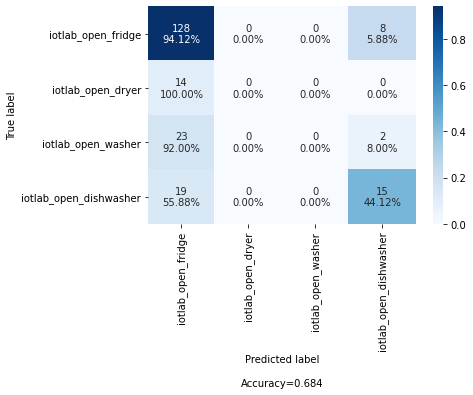

OvOSVC


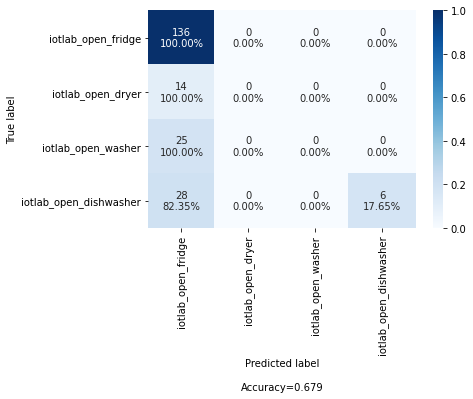

OvOGP


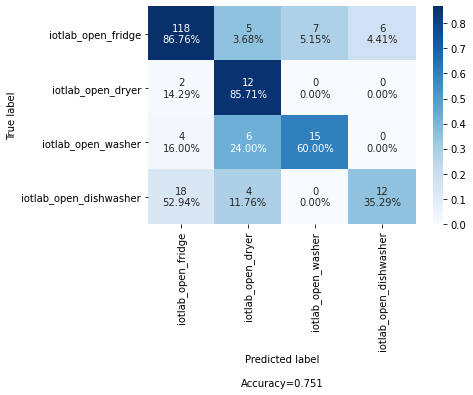

OvRLinearSVC


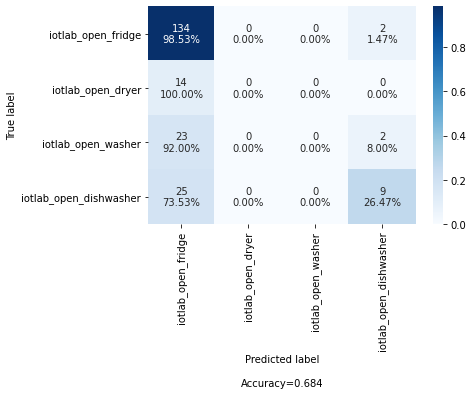

OvRLogReg


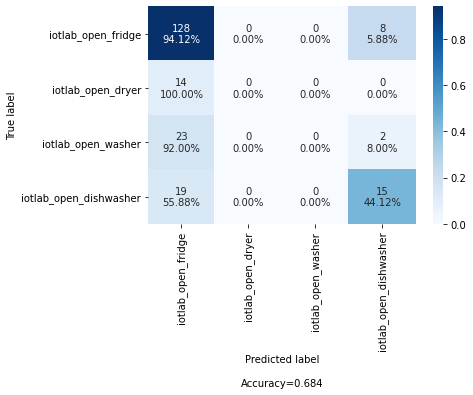

OvRGP


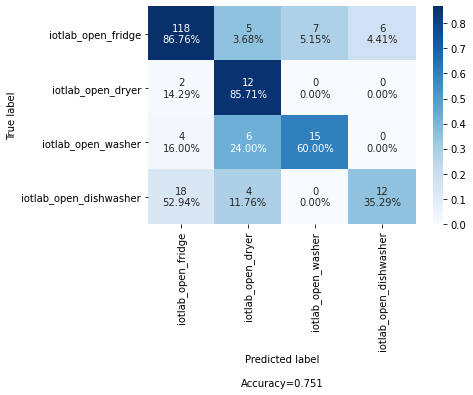

SAMP_SIZE
DecTree


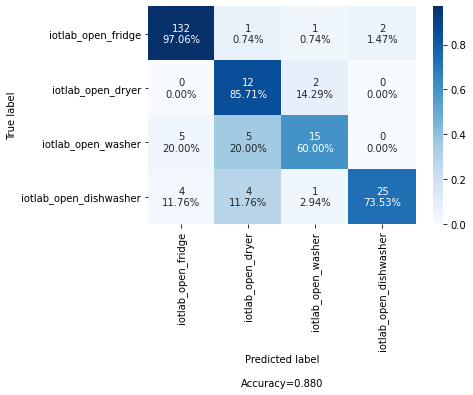

LogReg


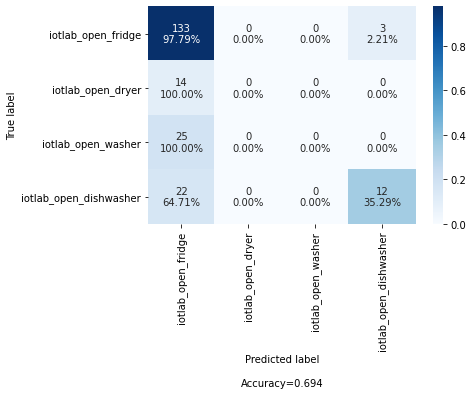

OvOSVC


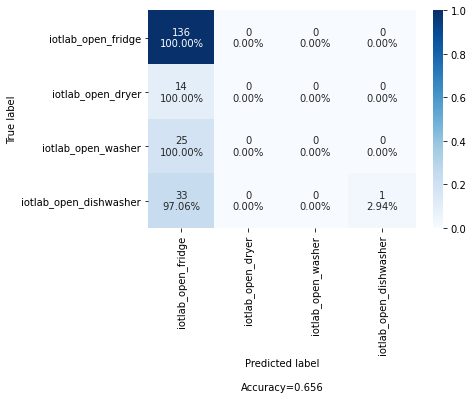

OvOGP


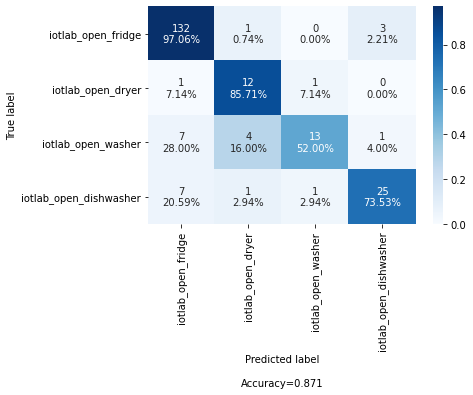

OvRLinearSVC


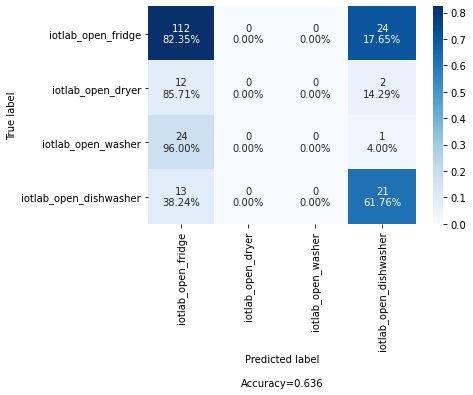

OvRLogReg


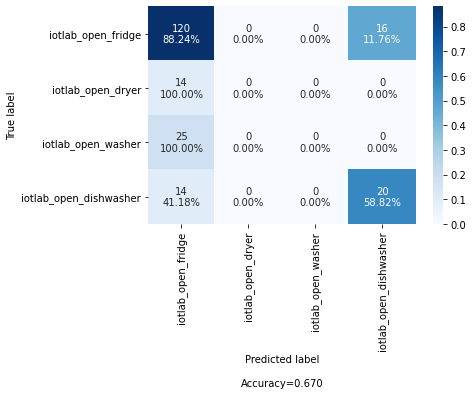

OvRGP


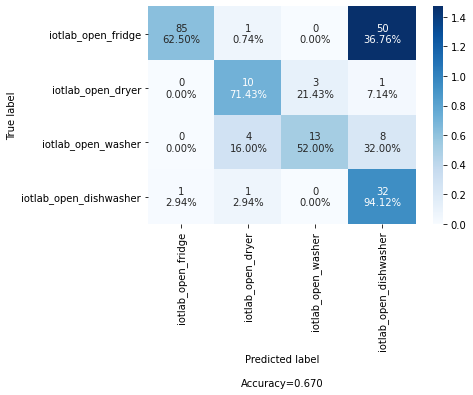

STATS
DecTree


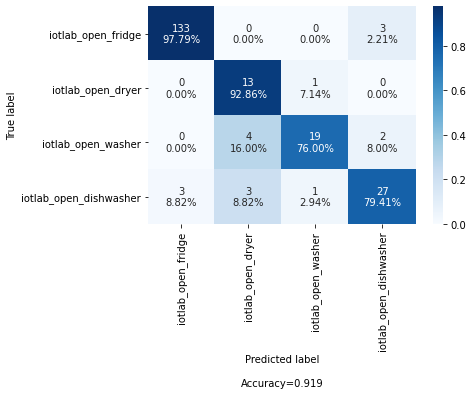

LogReg


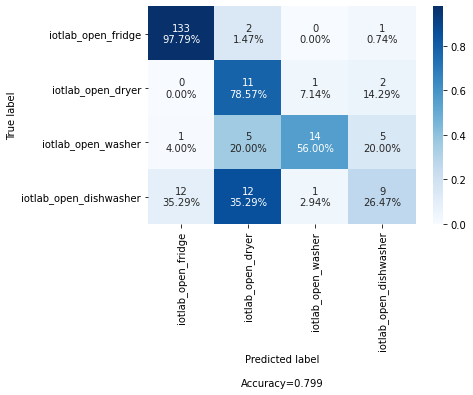

OvOSVC


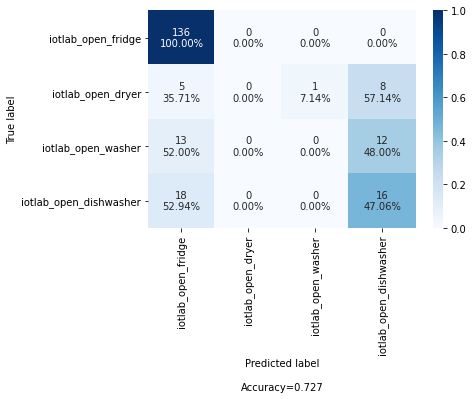

OvOGP


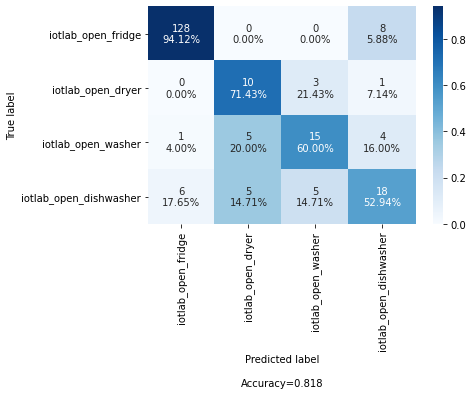

OvRLinearSVC


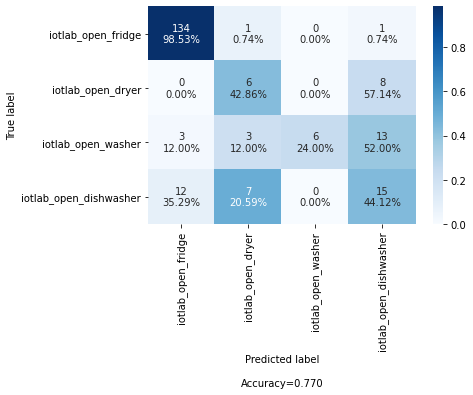

OvRLogReg


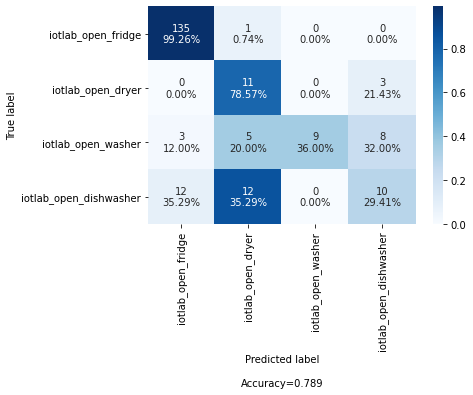

OvRGP


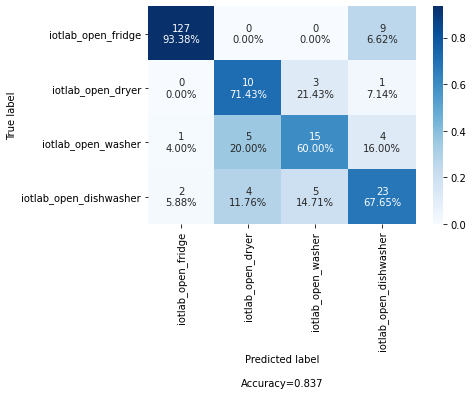

FFT-IAT
DecTree


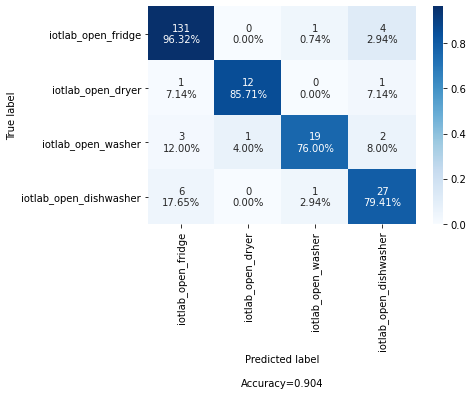

LogReg


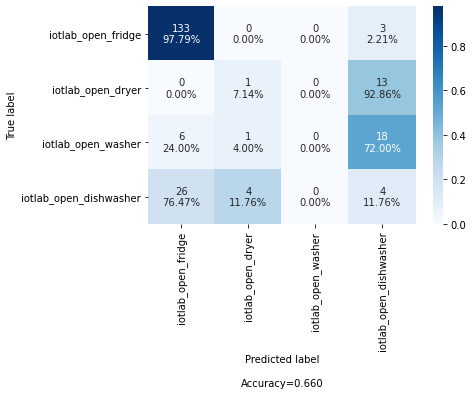

OvOSVC


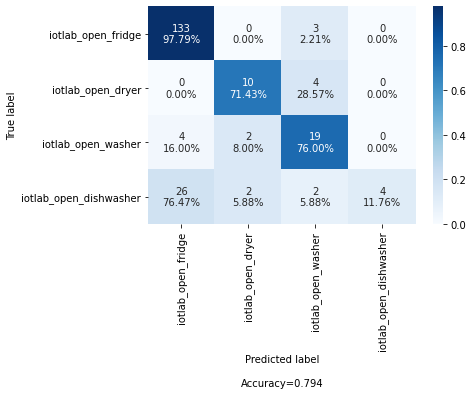

OvOGP


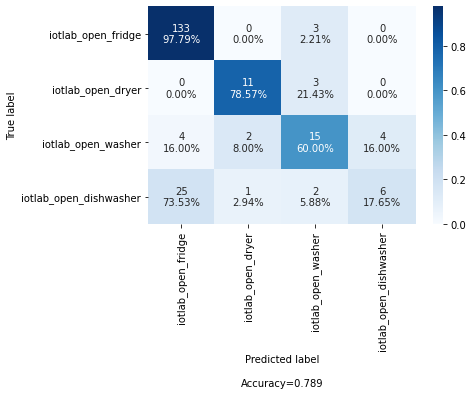

OvRLinearSVC


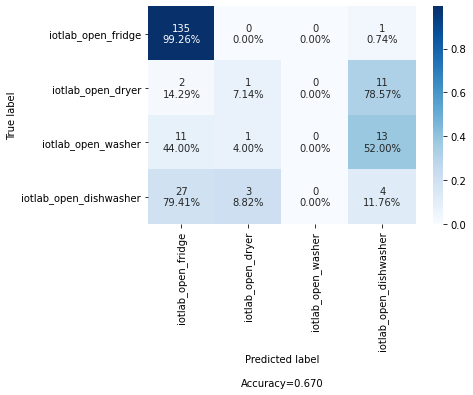

OvRLogReg


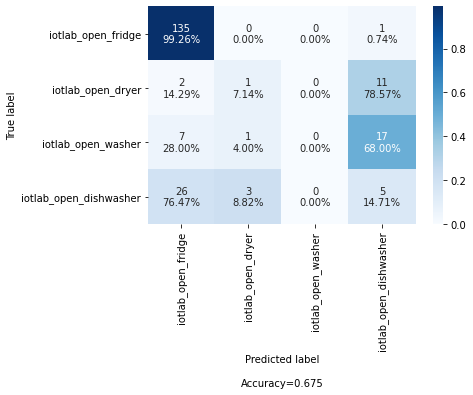

OvRGP


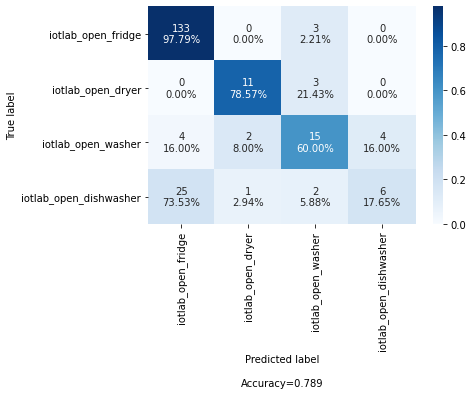

FFT-IAT_SIZE
DecTree


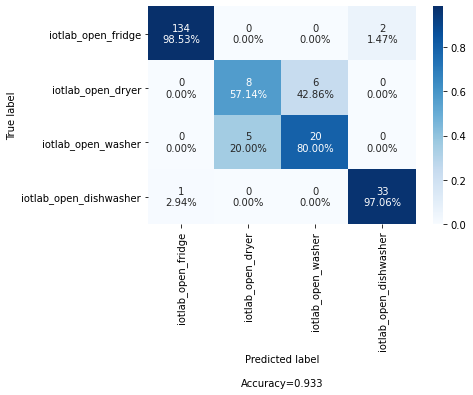

LogReg


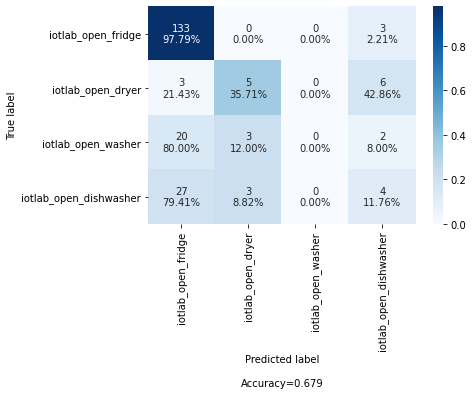

OvOSVC


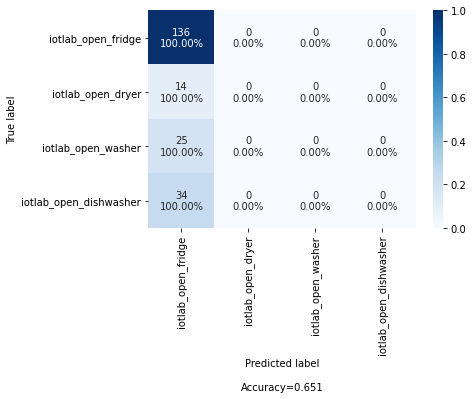

OvOGP


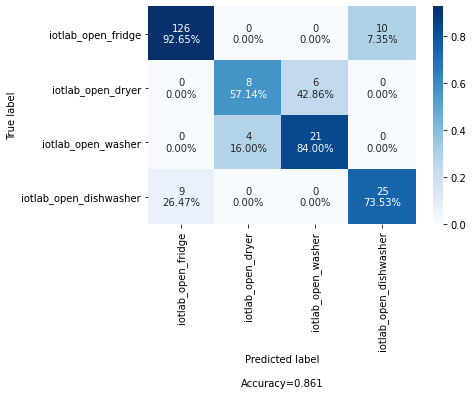

OvRLinearSVC


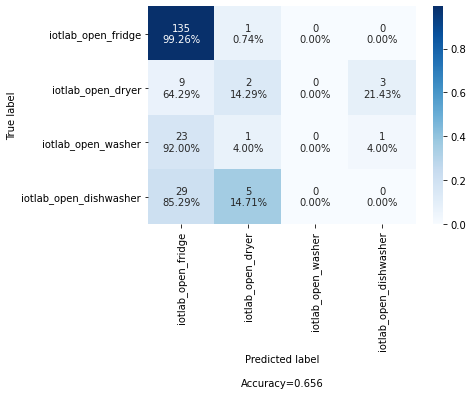

OvRLogReg


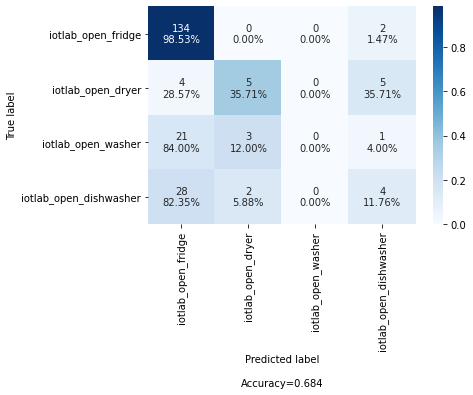

OvRGP


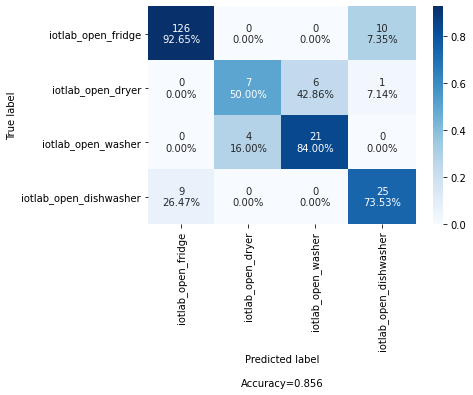

FFT-SIZE
DecTree


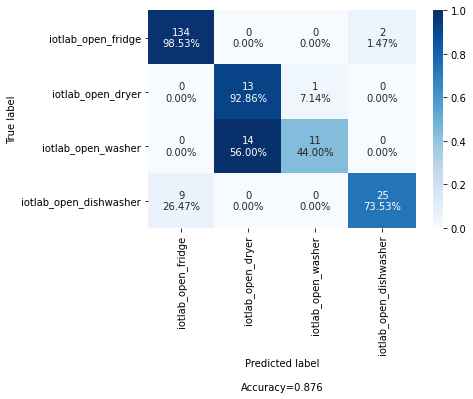

LogReg


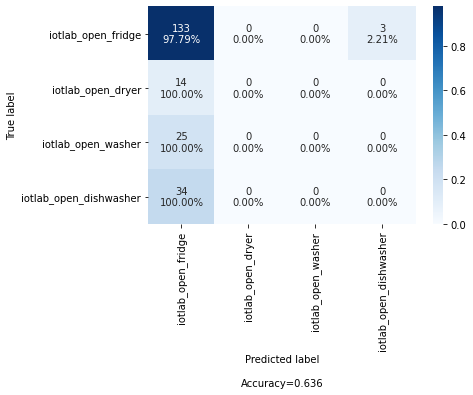

OvOSVC


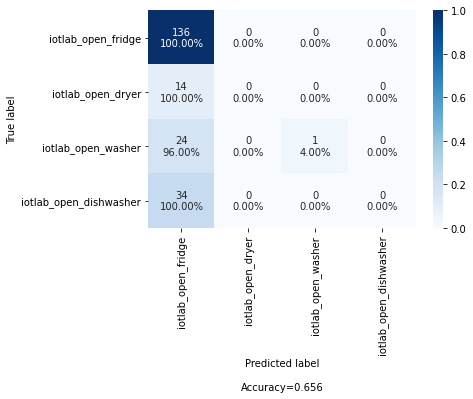

OvOGP


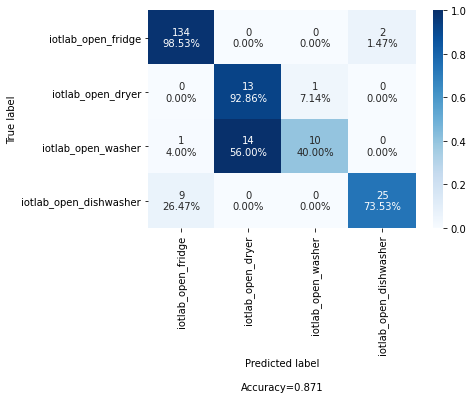

OvRLinearSVC


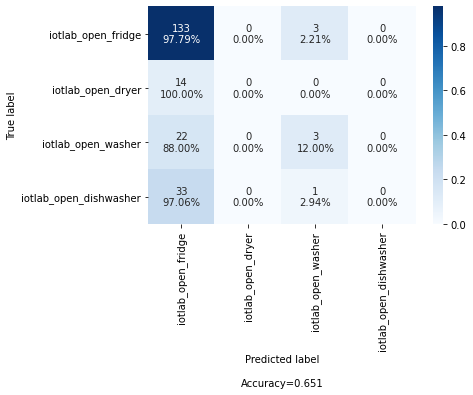

OvRLogReg


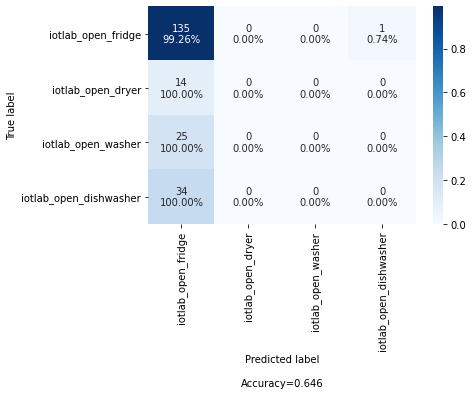

OvRGP


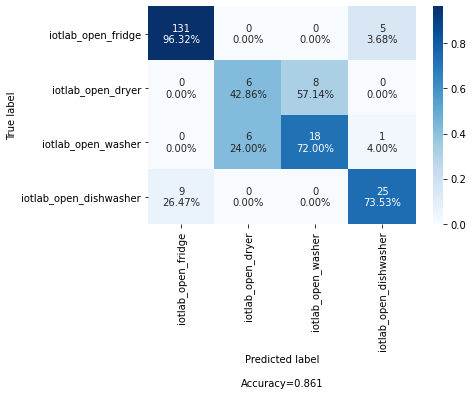

FFT-SAMP_NUM
DecTree


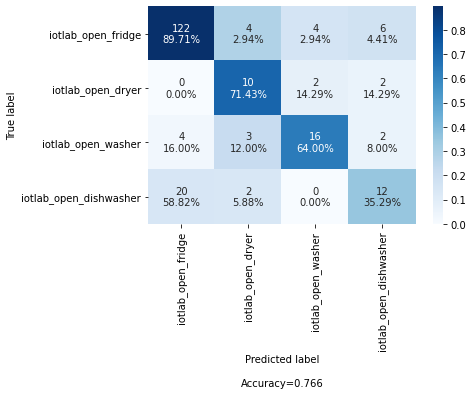

LogReg


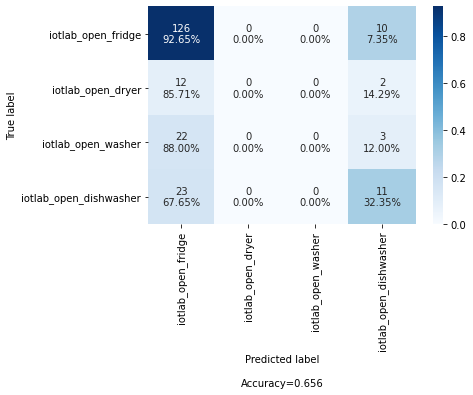

OvOSVC


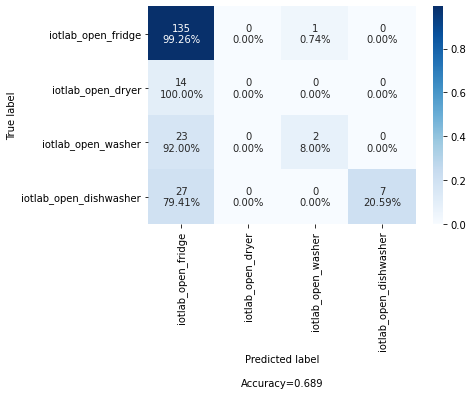

OvOGP


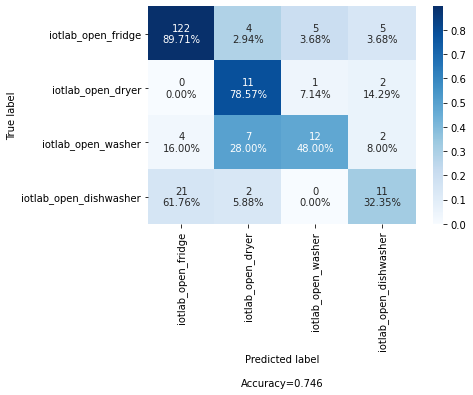

OvRLinearSVC


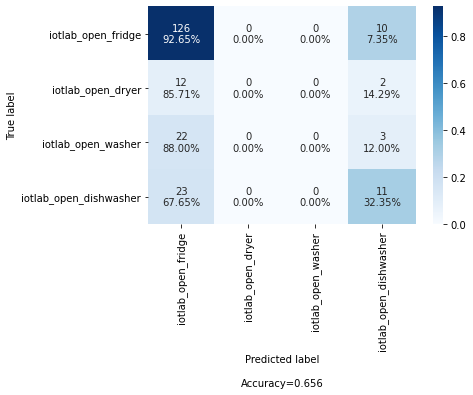

OvRLogReg


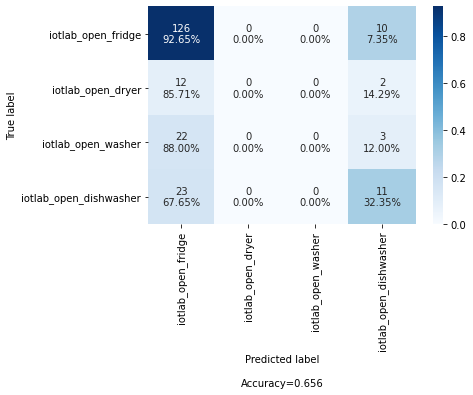

OvRGP


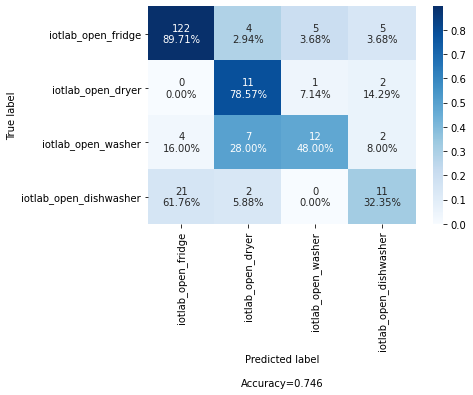

FFT-SAMP_SIZE
DecTree


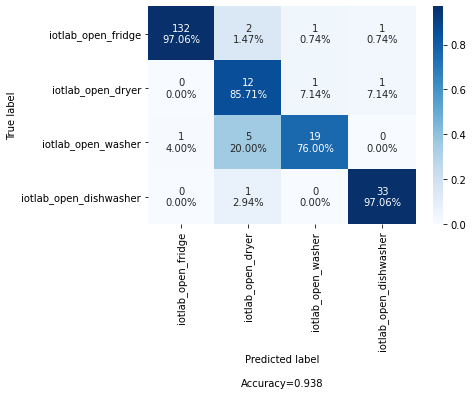

LogReg


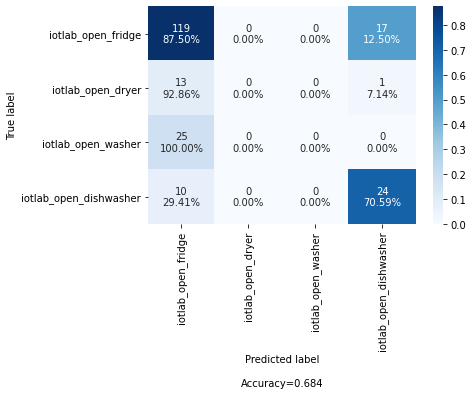

OvOSVC


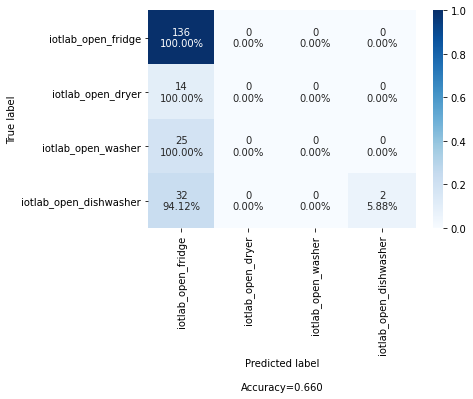

OvOGP


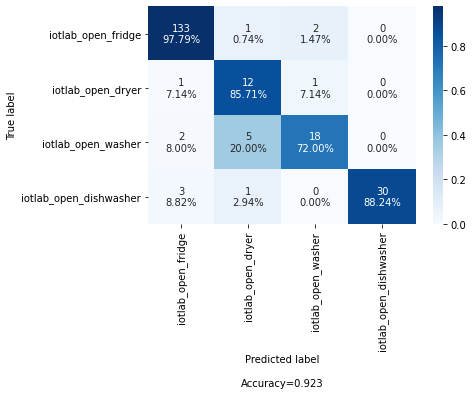

OvRLinearSVC


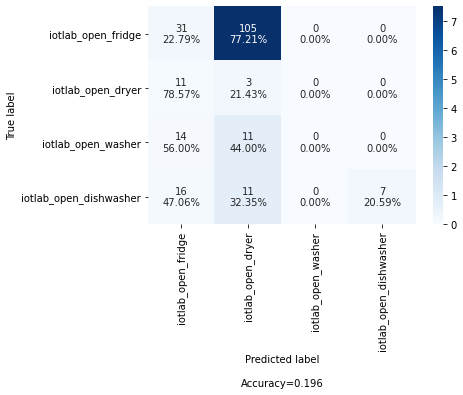

OvRLogReg


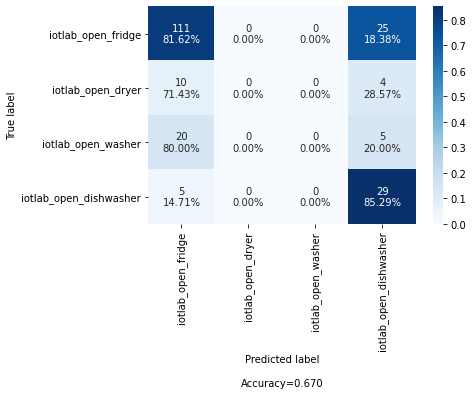

OvRGP


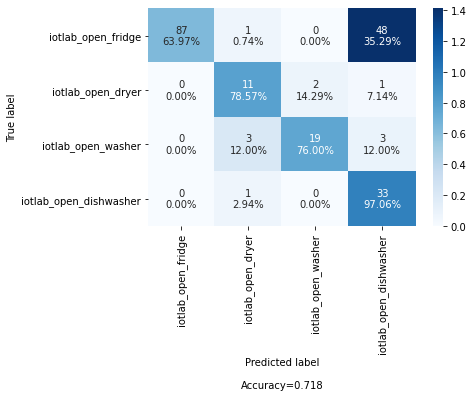

In [110]:
act_label = {"iotlab_open_fridge": 1, 
             "iotlab_open_dryer": 4, 
             "iotlab_open_washer": 5, 
             "iotlab_open_dishwasher": 6}

feat_types = ['IAT','SIZE','IAT_SIZE','SAMP_NUM','SAMP_SIZE','STATS',
                  'FFT-IAT','FFT-IAT_SIZE','FFT-SIZE','FFT-SAMP_NUM', 'FFT-SAMP_SIZE']
from warnings import filterwarnings
filterwarnings('ignore')

for feat in feat_types:
    print(feat)
    eval(feat)